# 1 - Introduction

### Business Problem Understanding

#### Context
E-Commerce company seeks to understand customer behavior better to enhance customer retention and improve marketing strategies. The dataset contains various attributes related to customer interactions with the company, including demographic information, transaction history, and engagement metrics. The company aims to identify which customers are likely to churn (stop using the service) so they can implement targeted retention strategies.

#### Target
- **0**: Not Churned
- **1**: Churned (stop using the service)

#### Problem Statement
Churn prediction is crucial for the company, as acquiring new customers is significantly more costly than retaining existing ones. The company needs to focus its retention efforts on high-risk customers based on various attributes to minimize churn and optimize marketing spend.

#### Goals
The company aims to:
1. Predict which customers are likely to churn in the near future.
2. Identify key factors that contribute to customer churn.
3. Implemented machine learning with recall above 90%, to predict customer churn. 
4. Develop targeted marketing strategies to retain high-risk customers.

#### Analytic Approach
To address the problem, we will:
1. Analyze the dataset to find patterns and correlations between customer attributes and churn.
2. Build a predictive model to classify customers as likely to churn or not based on historical data.
3. Evaluate model performance primarily using recall to ensure we effectively capture as many high-risk customers as possible.


#### Metric Evaluation

- Type 1 Error (False Positive) (Customer Retention Cost - CRC):
  - Consequence: Resources are wasted on retaining customers who are not at risk of churning. This results in an increased expense of approximately **$3 per customer** (retention effort 5-20% from CAC) for unnecessary retention efforts.

- Type 2 Error (False Negative) (Customer Acquisition Cost - CAC):
  - Consequence: Loss of customers who are actually at risk of churning. This leads to a cost of about **$20 per customer** in lost revenue, significantly affecting customer acquisition costs (CAC) due to potential churned customers who could have been retained.[Cost for Acquisition for small online stores](https://beprofit.co/a/blog/the-customer-acquisition-cost-in-e-commerce-and-industry)

#### Notes:
- The dataset includes both numerical and categorical features, with minimum cardinality.
- Some features heavily skewed, and the dataset imbalanced regarding the churn target.
- Each row represents a unique customer and their associated attributes.

**Dataset Source**: [kaggle](https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction)


# 2 - Import Libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, brier_score_loss
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, VotingClassifier)
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import (RandomOverSampler, SMOTE)
from imblearn.pipeline import Pipeline

import shap
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve

import pickle
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

RANDOM_STATE = 2024


# 3 - Data Understanding

### Features information

| Variable                        | Description                                                 |
|---------------------------------|-------------------------------------------------------------|
| CustomerID                      | Unique customer ID                                          |
| Churn                           | Churn Flag                                                 |
| Tenure                          | Tenure of customer in organization                         |
| PreferredLoginDevice            | Preferred login device of customer                         |
| CityTier                        | City tier                                                  |
| WarehouseToHome                 | Distance between warehouse and home of customer            |
| PreferredPaymentMode            | Preferred payment method of customer                        |
| Gender                          | Gender of customer                                         |
| HourSpendOnApp                 | Number of hours spent on mobile application or website     |
| NumberOfDeviceRegistered        | Total number of devices registered for a particular customer|
| PreferedOrderCat                | Preferred order category of customer in last month         |
| SatisfactionScore               | Satisfaction score of customer on service                  |
| MaritalStatus                   | Marital status of customer                                 |
| NumberOfAddress                 | Total number of addresses added by customer                |
| Complain                        | Any complaint raised in last month                          |
| OrderAmountHikeFromLastYear    | Percentage increase in orders from last year               |
| CouponUsed                      | Total number of coupons used in last month                 |
| OrderCount                      | Total number of orders placed in last month                |
| DaySinceLastOrder              | Days since last order by customer                           |
| CashbackAmount                  | Average cashback in last month                              |


### Load Dataset

In [157]:
# Load dataset
df = pd.read_excel('ecommerce.xlsx', sheet_name='E Comm')
df_duplicate = df.copy()
df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


### Data Charachteristics

In [158]:
df.shape

(5630, 20)

The dataset includes 5,630 rows and 20 columns, indicating a relatively small amount of data.

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

From 5,630 entries, the features contains 7 integers, 8 floats, and 5 objects of data types. Notably, several columns exhibit missing values.

In [160]:
# Count duplicated rows excluding 'CustomerID'
df.duplicated().sum()

0

There are no duplicate entries across all attributes in the dataset. However, for further modeling, some unused columns might will be removed after conducting exploratory data analysis (EDA).

In [161]:
# Mising & Unique Values Information
pd.DataFrame({
    'Null Count': df.isnull().sum(),
    'Unique Count': [df[col].nunique() for col in df.columns],
    'Unique values': [df[col].unique() for col in df.columns]
})


,Null Count,Unique Count,Unique values
CustomerID,0,5630,"[50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009, 50010, 50011, 50012, 50013, 50014, 50015, 50016, 50017, 50018, 50019, 50020, 50021, 50022, 50023, 50024, 50025, 50026, 50027, 50028, 50029, 50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046, 50047, 50048, 50049, 50050, 50051, 50052, 50053, 50054, 50055, 50056, 50057, 50058, 50059, 50060, 50061, 50062, 50063, 50064, 50065, 50066, 50067, 50068, 50069, 50070, 50071, 50072, 50073, 50074, 50075, 50076, 50077, 50078, 50079, 50080, 50081, 50082, 50083, 50084, 50085, 50086, 50087, 50088, 50089, 50090, 50091, 50092, 50093, 50094, 50095, 50096, 50097, 50098, 50099, 50100, ...]"
Churn,0,2,"[1, 0]"
Tenure,264,36,"[4.0, nan, 0.0, 13.0, 11.0, 9.0, 19.0, 20.0, 14.0, 8.0, 18.0, 5.0, 2.0, 30.0, 1.0, 23.0, 3.0, 29.0, 6.0, 26.0, 28.0, 7.0, 24.0, 25.0, 10.0, 15.0, 22.0, 27.0, 16.0, 12.0, 21.0, 17.0, 50.0, 60.0, 31.0, 51.0, 61.0]"
PreferredLoginDevice,0,3,"[Mobile Phone, Phone, Computer]"
CityTier,0,3,"[3, 1, 2]"
WarehouseToHome,251,34,"[6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, 31.0, 18.0, 13.0, 20.0, 29.0, 28.0, 26.0, 14.0, nan, 10.0, 27.0, 17.0, 23.0, 33.0, 19.0, 35.0, 24.0, 16.0, 25.0, 32.0, 34.0, 5.0, 21.0, 126.0, 7.0, 36.0, 127.0]"
PreferredPaymentMode,0,7,"[Debit Card, UPI, CC, Cash on Delivery, E wallet, COD, Credit Card]"
Gender,0,2,"[Female, Male]"
HourSpendOnApp,255,6,"[3.0, 2.0, nan, 1.0, 0.0, 4.0, 5.0]"
NumberOfDeviceRegistered,0,6,"[3, 4, 5, 2, 1, 6]"


Concerning the missing values, seven features have NULL entries. The `CustomerID` serves as a unique identifier and is entirely unique, following about 2,586 entries for the cashback amount. Meanwhile, the categorical features each have fewer than 10 unique categories. It’s also important to examine the unique values for each feature, as they may contain variations or misspellings of the same values. 

In [162]:
# Proportion of Missing Values

missing_values_proportion = pd.DataFrame({
    'total missing values': df.isnull().sum(),
    'percentage': round(df.isnull().sum() / len(df) * 100, 2),
    'dtype': df.dtypes
})

missing_values_proportion[missing_values_proportion['total missing values'] > 0].sort_values(by='percentage', ascending=False)

,total missing values,percentage,dtype
DaySinceLastOrder,307,5.45,float64
OrderAmountHikeFromlastYear,265,4.71,float64
Tenure,264,4.69,float64
OrderCount,258,4.58,float64
CouponUsed,256,4.55,float64
HourSpendOnApp,255,4.53,float64
WarehouseToHome,251,4.46,float64


The missing values are distributed across seven numerical columns, with an average of approximately 5% missing in each. To determine the best approach for addressing the missing data—whether through deletion or imputation—it’s important to examine the characteristics of each feature first.

In [163]:
missing_values_proportion[missing_values_proportion['total missing values'] > 0].sort_values(by='percentage', ascending=False).index

Index(['DaySinceLastOrder', 'OrderAmountHikeFromlastYear', 'Tenure',
       'OrderCount', 'CouponUsed', 'HourSpendOnApp', 'WarehouseToHome'],
      dtype='object')

In [164]:
# Proportion of Churn in dataset

round(df['Churn'].value_counts() / len(df), 2)

Churn
0    0.83
1    0.17
Name: count, dtype: float64

The proportion shows that 83% of customers remain with our company, while 17% have left or are at risk of leaving. This high retention rate suggests that churn is relatively low, but the 17% at risk may still impact machine learning models. The limited number of churn instances could pose challenges in accurately identifying churn characteristics, as the model may struggle to detect meaningful patterns from the smaller group of customers who churn. This imbalance may require special handling techniques, such as resampling or adjusting class weights, to improve the model’s performance in predicting churn.

# 4 - Preprocessing

In [165]:
cat_columns = ['PreferredLoginDevice', 
               'PreferredPaymentMode', 
               'Gender', 
               'Complain',
               'PreferedOrderCat', 
               'MaritalStatus']
num_columns = ['Tenure',
                'WarehouseToHome',
                'HourSpendOnApp',
                'NumberOfDeviceRegistered',
                'SatisfactionScore',
                'NumberOfAddress',
                'OrderAmountHikeFromlastYear',
                'CouponUsed',
                'OrderCount',
                'DaySinceLastOrder',
                'CashbackAmount']

#### Data Cleaning

<Axes: >

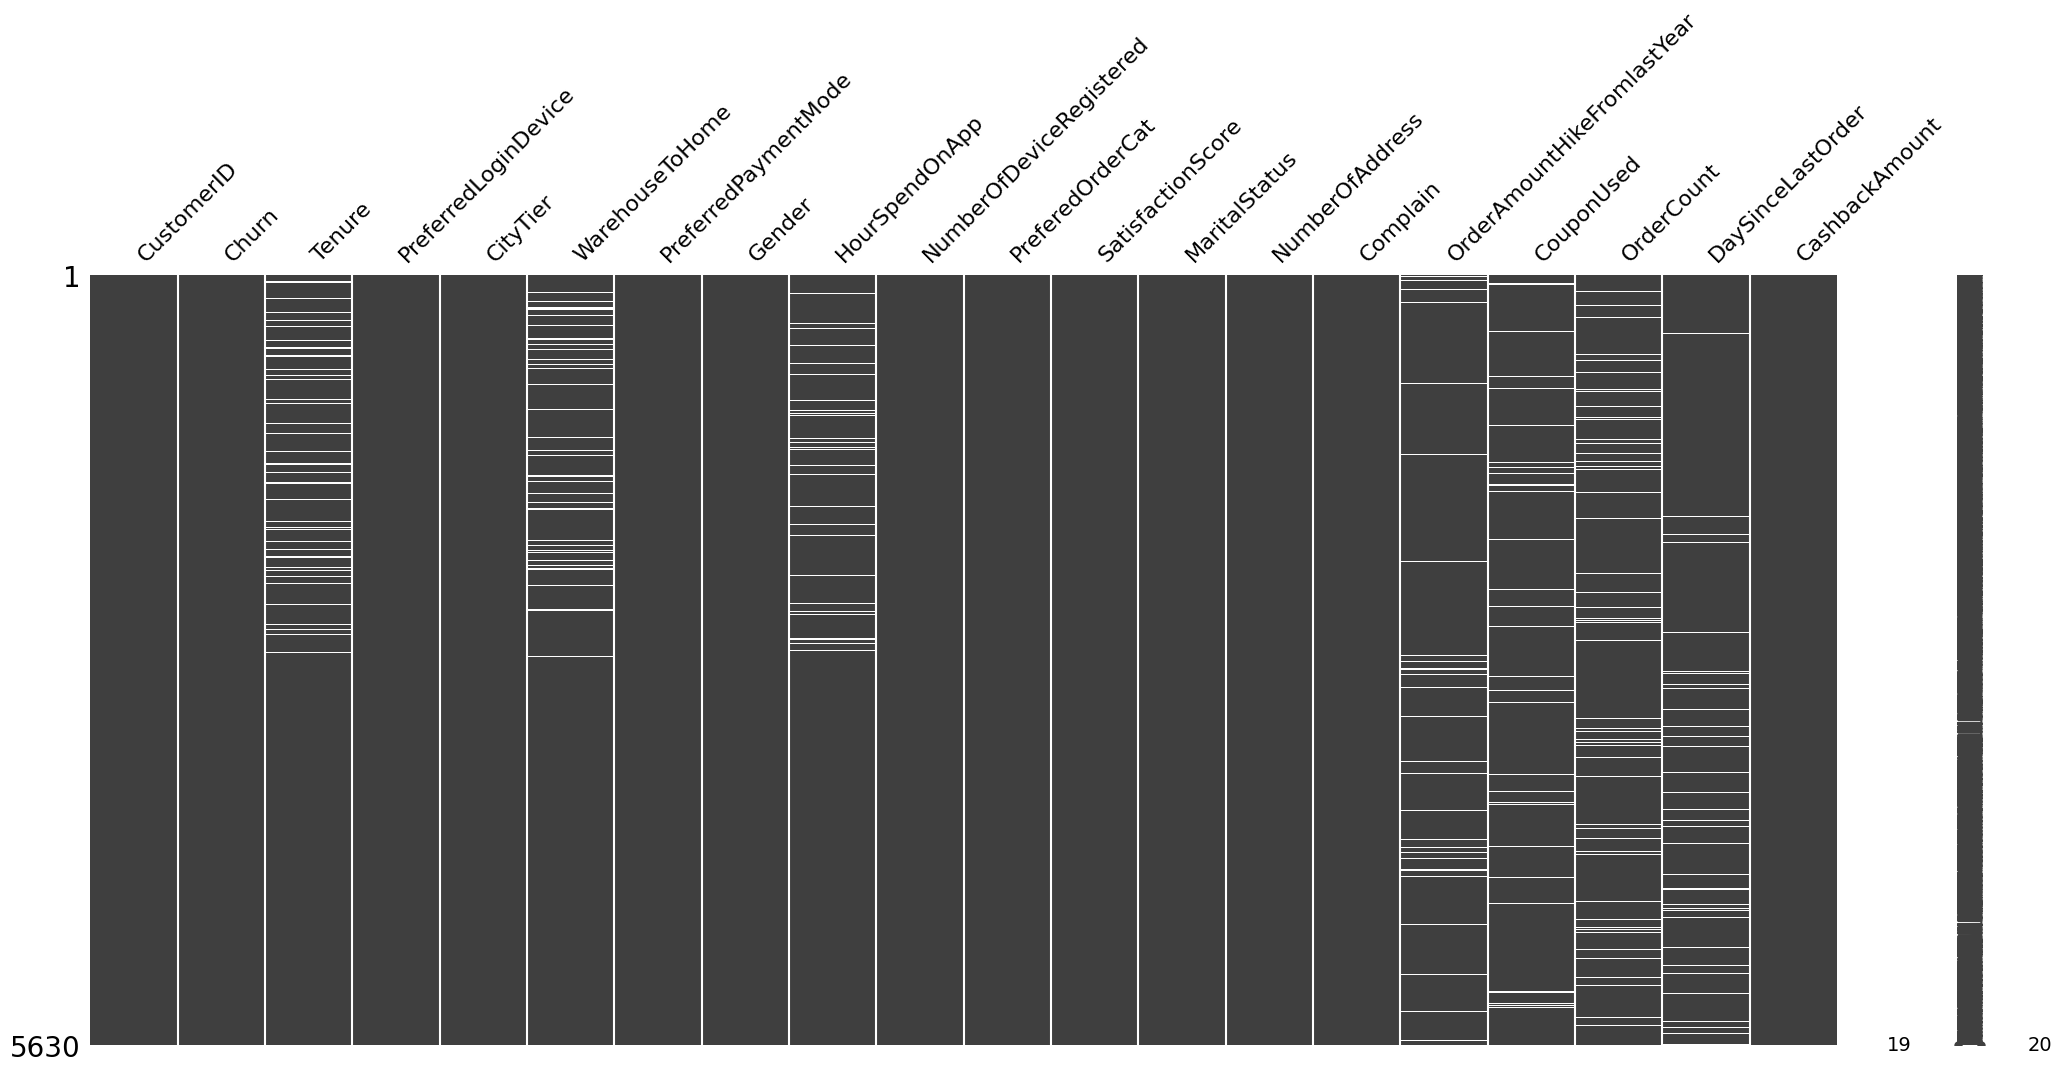

In [166]:
missingno.matrix(df)

Based on the visualization, we will analyze how to address the missing values in the numerical features, specifically in the columns `DaySinceLastOrder`, `OrderAmountHikeFromlastYear`, `Tenure`, `OrderCount`, `CouponUsed`, `HourSpendOnApp`, `WarehouseToHome`. This will involve deciding whether to fill in or delete these missing values.

In [167]:
df[df.isnull().any(axis=1)]


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
6,50007,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,Laptop & Accessory,2,Divorced,4,0,14.0,0.0,1.0,0.0,120.86
7,50008,1,NaN,Phone,1,6.0,CC,Male,3.0,3,Mobile,2,Divorced,3,1,16.0,2.0,2.0,0.0,122.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5610,55611,0,9.0,Mobile Phone,2,33.0,Debit Card,Female,3.0,4,Fashion,1,Single,3,1,17.0,2.0,2.0,NaN,213.37
5621,55622,1,14.0,Mobile Phone,3,35.0,E wallet,Male,3.0,5,Fashion,5,Married,6,1,14.0,3.0,NaN,1.0,233.54
5622,55623,0,13.0,Mobile Phone,3,31.0,E wallet,Female,3.0,5,Grocery,1,Married,2,0,12.0,4.0,NaN,7.0,245.31
5623,55624,0,5.0,Computer,1,12.0,Credit Card,Male,4.0,4,Laptop & Accessory,5,Single,2,0,20.0,2.0,2.0,NaN,224.36


<Axes: >

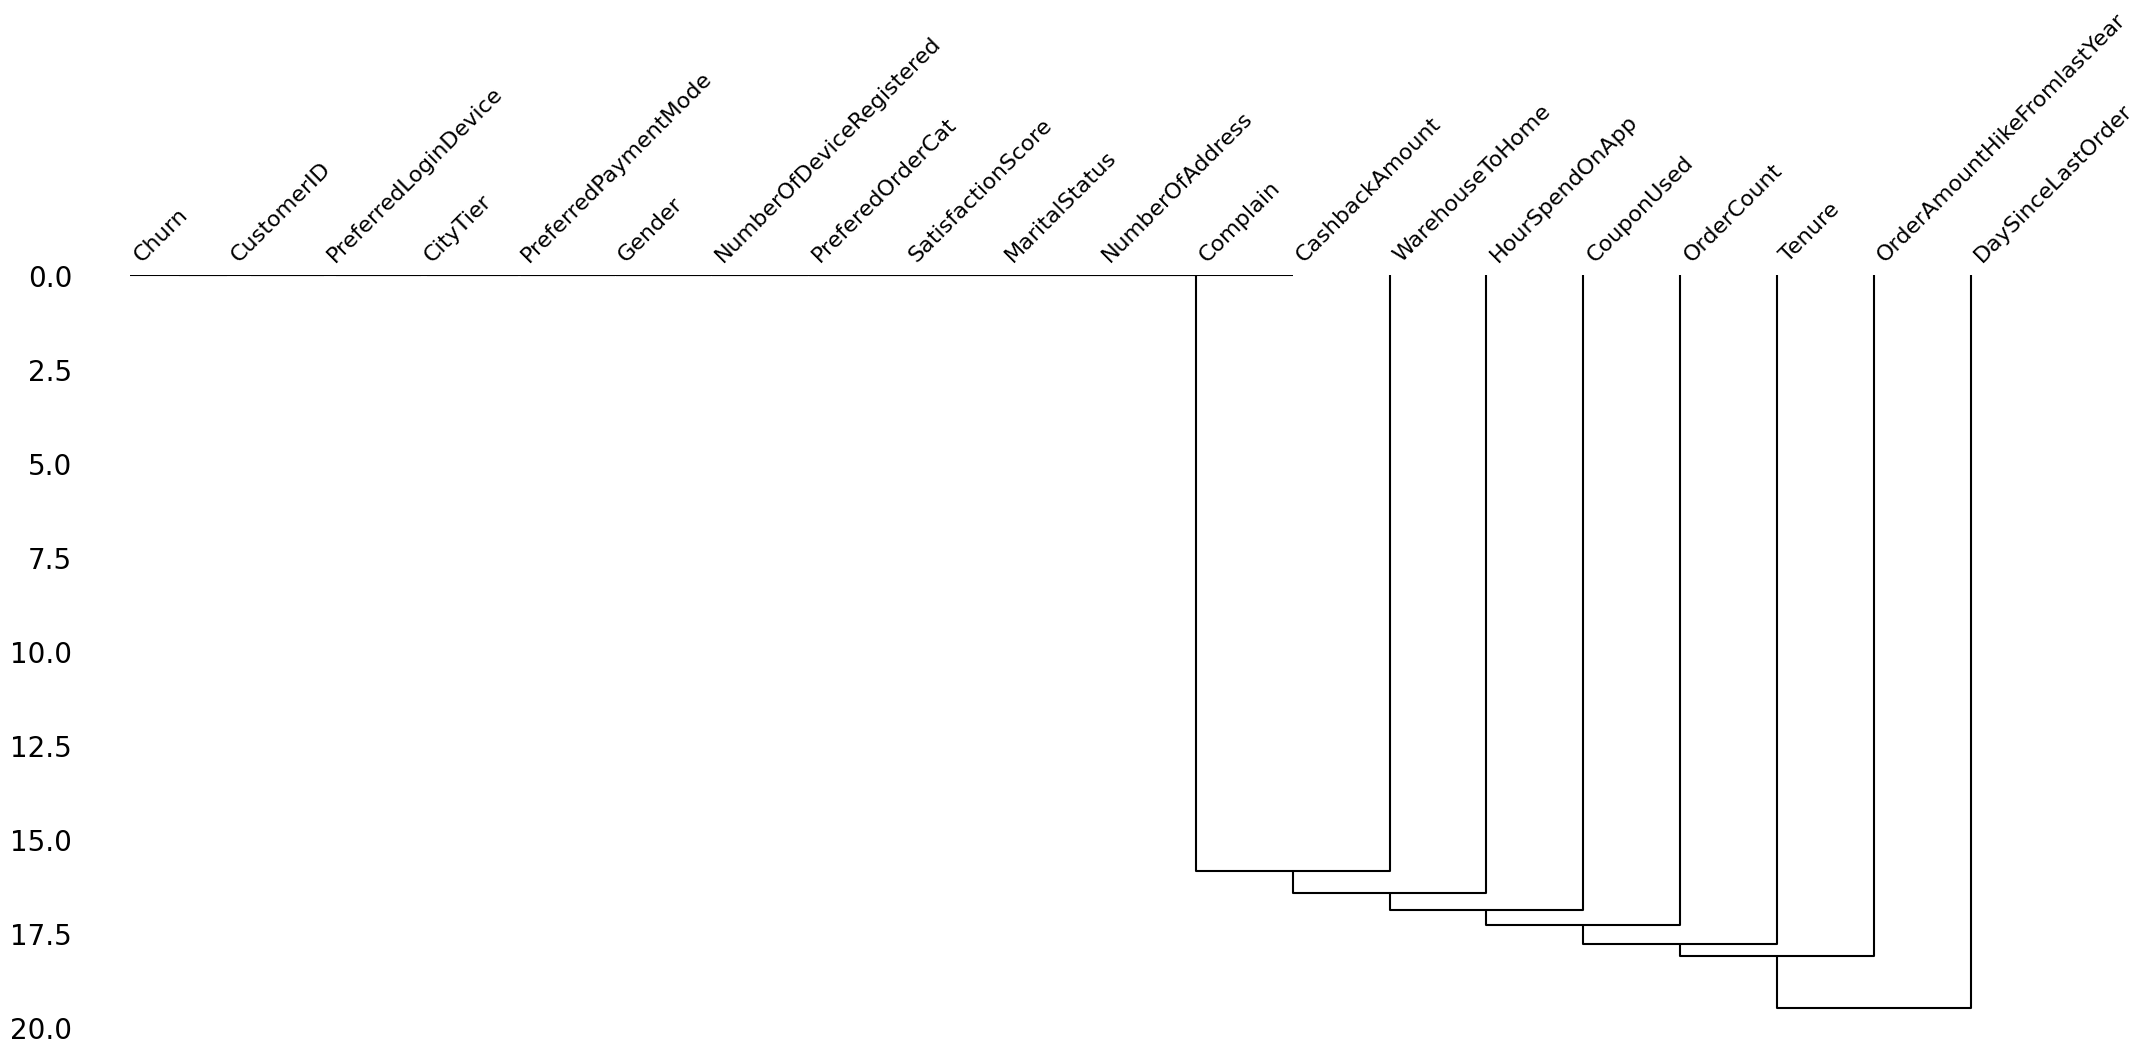

In [168]:
missingno.dendrogram(df)

Dendrogram shows how the features in dataset are clustered based on their patterns of missing values. The closer two features are in the dendrogram, the more similar their missing value patterns are. Features like `CashbackAmount` and `WarehouseToHome` are grouped together, indicating that they may share a similar pattern of missing data. On the other hand, features like `OrderAmountHikeFromLastYear` and `DaysSinceLastOrder` form their own cluster, which suggests these fields might have missing values that occur under similar conditions.

In [169]:
# Calculate skewness of numerical columns
skewness = df[num_columns].skew()
skewness


Tenure                         0.736513
WarehouseToHome                1.619154
HourSpendOnApp                -0.027213
NumberOfDeviceRegistered      -0.396969
SatisfactionScore             -0.142626
NumberOfAddress                1.088639
OrderAmountHikeFromlastYear    0.790785
CouponUsed                     2.545653
OrderCount                     2.196414
DaySinceLastOrder              1.191000
CashbackAmount                 1.149846
dtype: float64

In [170]:
# Function for plotting numerical features
def plot_histogram(df, numerical_columns, churn_column):
    num_cols = len(numerical_columns)
    num_rows = (num_cols + 1) // 2 

    fig, ax = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 10 * num_rows))

    for i, column in enumerate(numerical_columns):
        row, col = divmod(i, 2) 
        sns.histplot(
            x=df[column],
            kde=True,
            ax=ax[row, col],
            palette='coolwarm',
        )
        ax[row, col].set_title(f'Distribution of {column}', y=1.1)

    for j in range(i + 1, num_rows * 2):
        fig.delaxes(ax.flatten()[j])

    plt.subplots_adjust(
        left=0.1, bottom=0.3, right=0.9, wspace=0.1, hspace=0.4
    )
    plt.show()

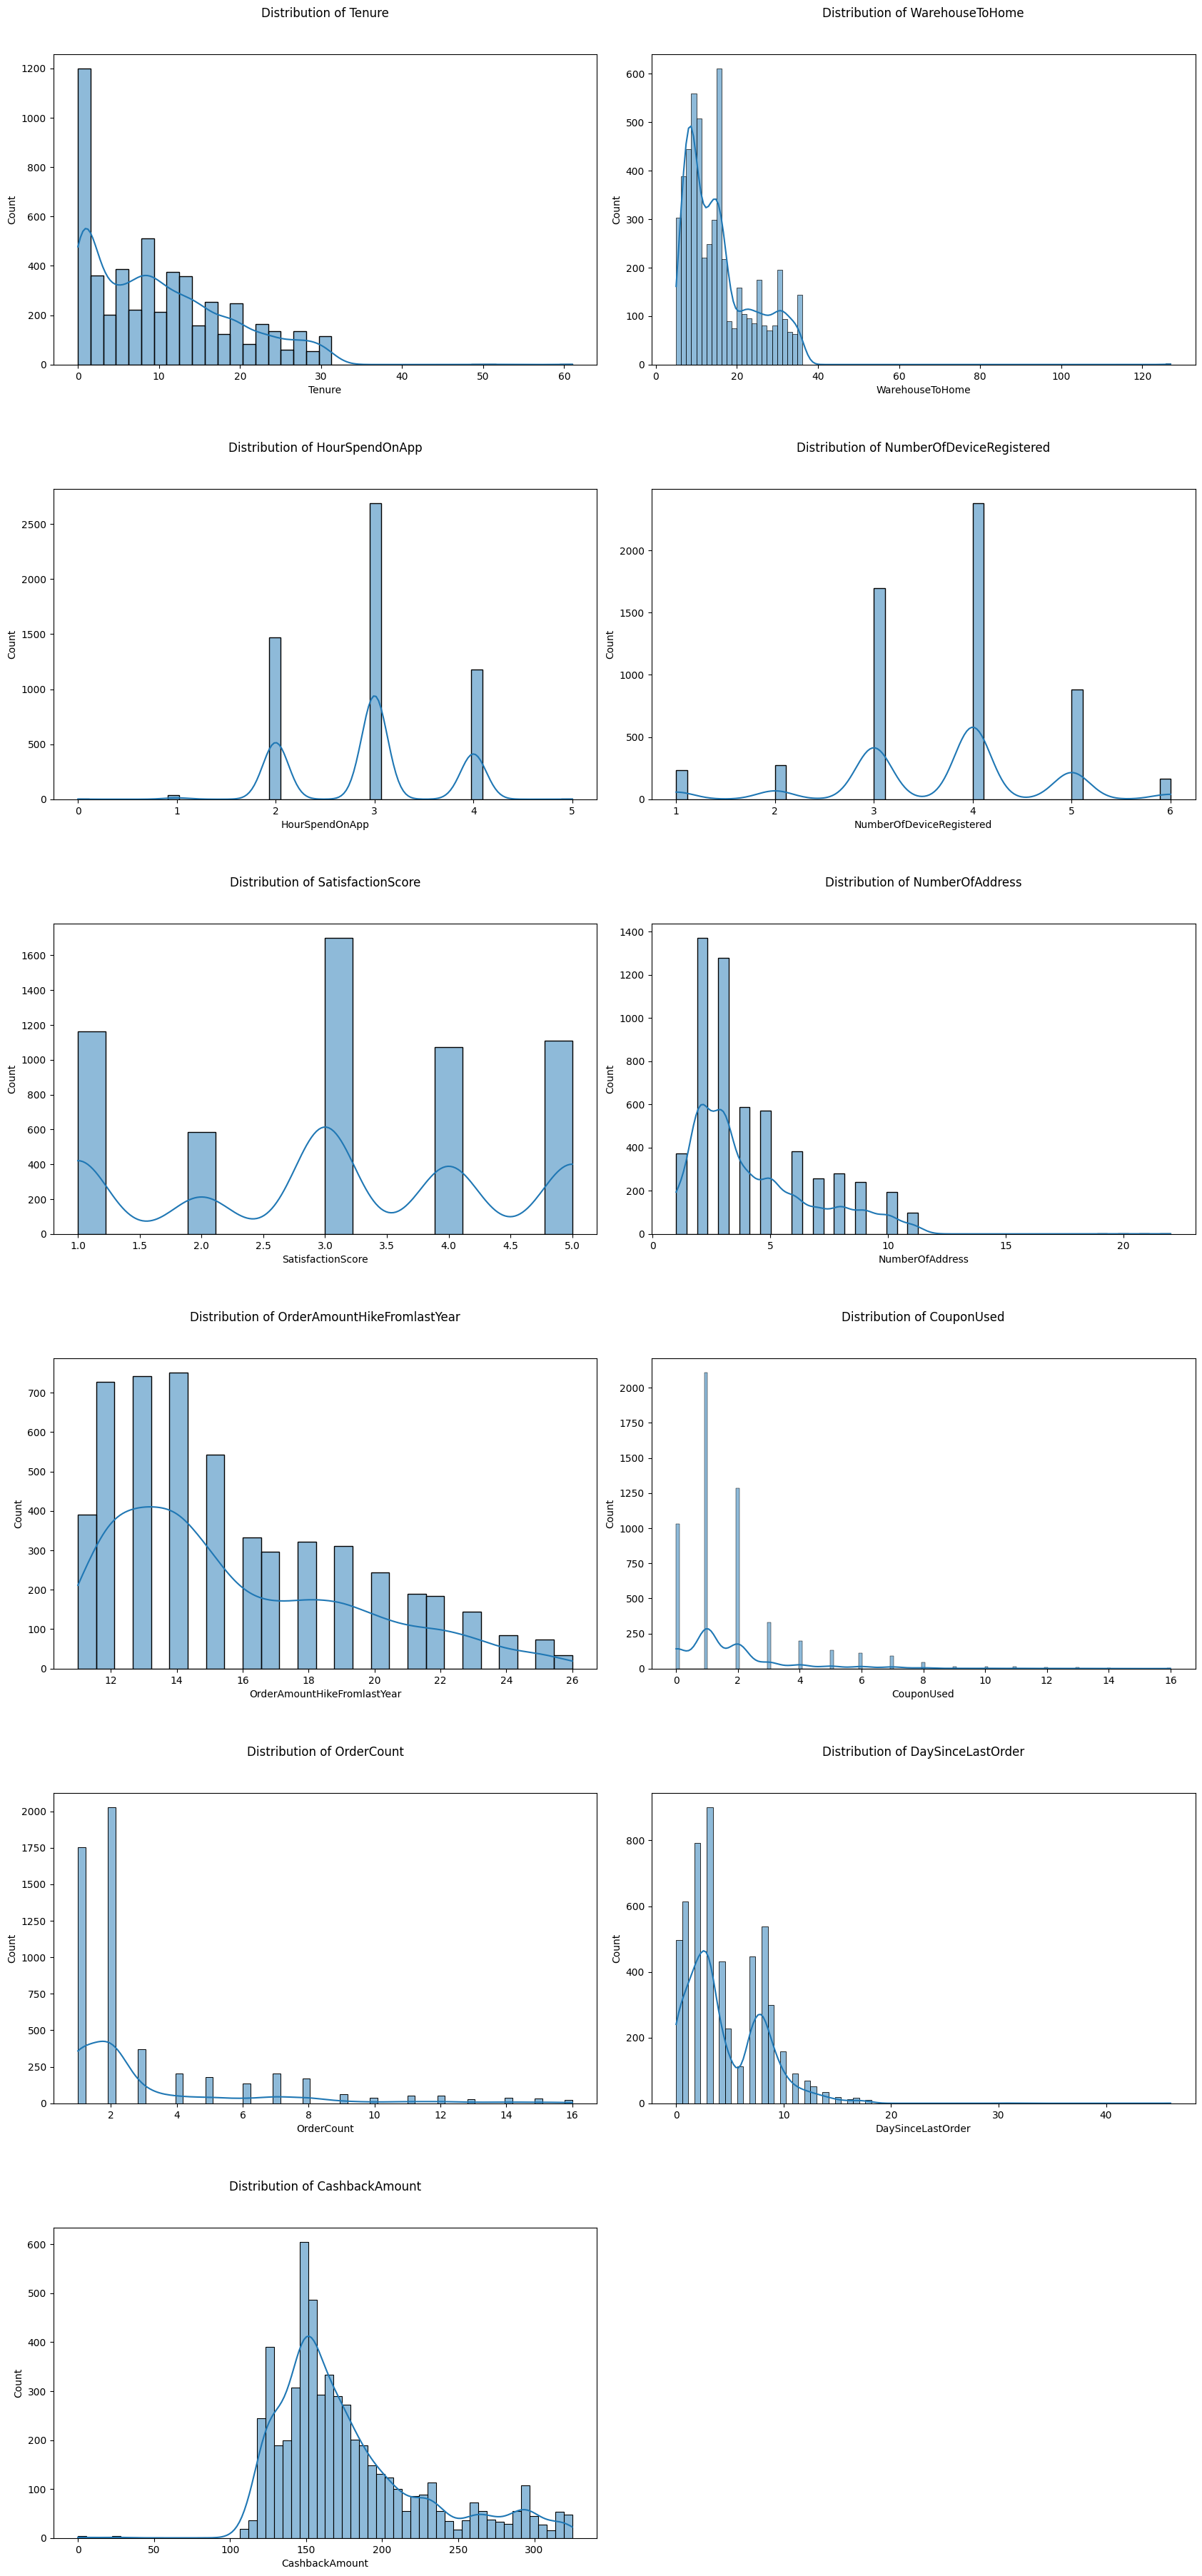

In [171]:
plot_histogram(df, num_columns, 'Churn')

- `Tenure` (0.766): Slightly positively skewed, indicating a longer tail on the right. This suggests most customers have shorter tenures, with a few having significantly longer tenures.

- `WarehouseToHome` (1.680): Highly positively skewed. This indicates that a majority of values are concentrated at the lower end, with a few customers using the service extensively.

- `HourSpendOnApp` (-0.041): Nearly symmetrical. This suggests that the distribution of app usage time is balanced, with no significant skew.

- `NumberOfDeviceRegistered` (-0.397): Moderately negatively skewed, indicating that most users register fewer devices, but some register many.

- `SatisfactionScore` (-0.143): Slightly negatively skewed, suggesting that most customers report high satisfaction, with a few expressing lower satisfaction.

- `NumberOfAddress` (1.089): Positively skewed, indicating that while most customers have few addresses registered, some have significantly more.

- `OrderAmountHikeFromlastYear` (0.837): Positively skewed, indicating that while most customers see small increases in order amounts, some see much larger increases.

- `CouponUsed` (2.630): Highly positively skewed, suggesting that a majority of customers use few coupons, while a small number use many.

- `OrderCount` (2.277): Highly positively skewed, indicating that most customers place a few orders, while a small number place many orders.

- `DaySinceLastOrder` (1.252): Positively skewed, suggesting that most customers have ordered recently, but some have not ordered in a long time.

- `CashbackAmount` (1.150): Positively skewed, indicating that most customers receive small cashback amounts, while a few receive significantly larger amounts.


Based on the visualization, it appears that all the numerical values are likely skewed. To improve the distribution of these values, we can fill in the missing values with the median.

In [172]:
# Fill the missing values based on Churn with their median

df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'WarehouseToHome'].median(), 1: df.loc[df['Churn'] == 1, 'WarehouseToHome'].median()}))
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'HourSpendOnApp'].median(), 1: df.loc[df['Churn'] == 1, 'HourSpendOnApp'].median()}))
df['CouponUsed'] = df['CouponUsed'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'CouponUsed'].median(), 1: df.loc[df['Churn'] == 1, 'CouponUsed'].median()}))
df['OrderCount'] = df['OrderCount'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'OrderCount'].median(), 1: df.loc[df['Churn'] == 1, 'OrderCount'].median()}))
df['Tenure'] = df['Tenure'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'Tenure'].median(), 1: df.loc[df['Churn'] == 1, 'Tenure'].median()}))
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'OrderAmountHikeFromlastYear'].median(), 1: df.loc[df['Churn'] == 1, 'OrderAmountHikeFromlastYear'].median()}))
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'DaySinceLastOrder'].median(), 1: df.loc[df['Churn'] == 1, 'DaySinceLastOrder'].median()}))
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['Churn'].map({0: df.loc[df['Churn'] == 0, 'DaySinceLastOrder'].median(), 1: df.loc[df['Churn'] == 1, 'DaySinceLastOrder'].median()}))

<Axes: >

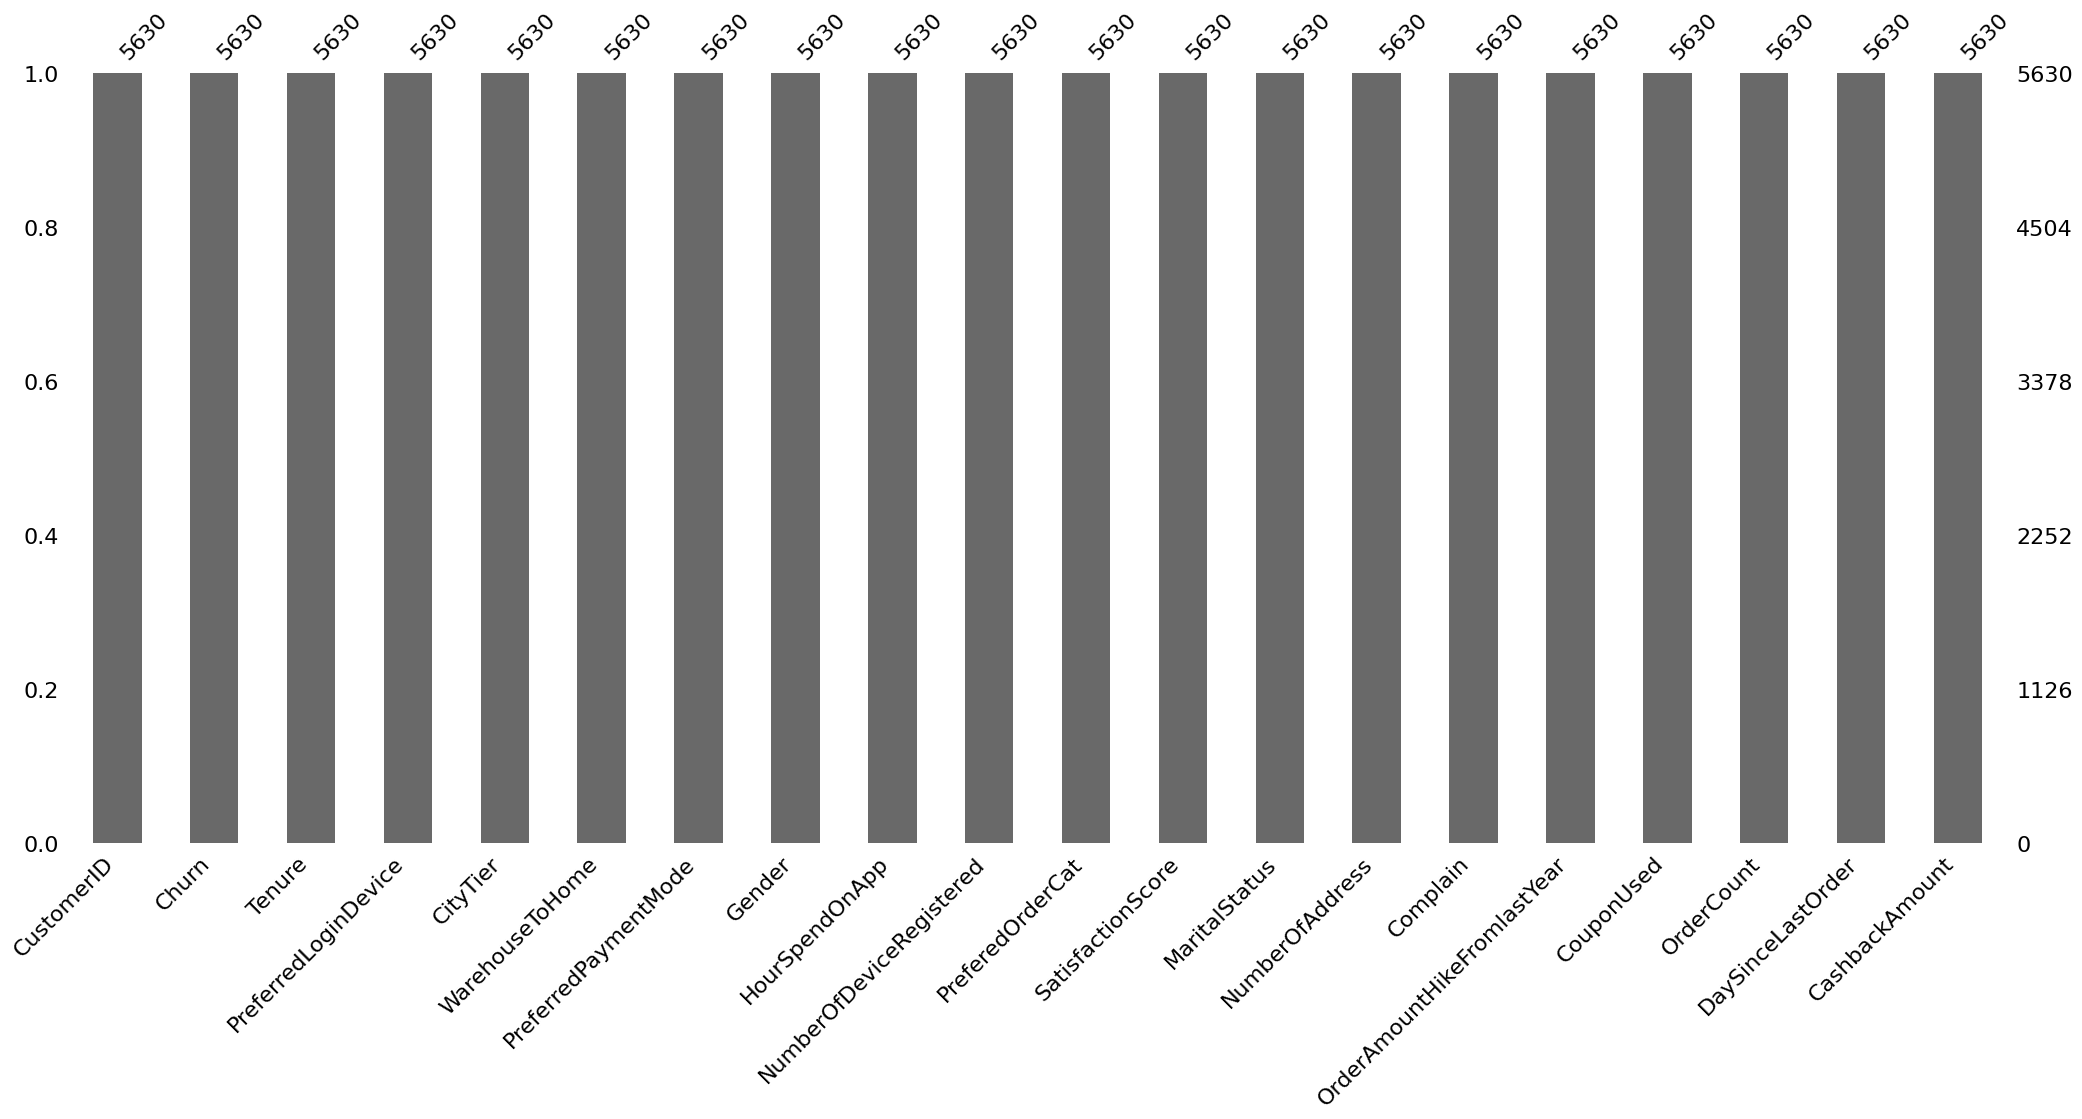

In [173]:
# Check again missing values specially for numerical features

missingno.bar(df)

Currently, there is no missing values in the data, particularly with the numerical features. However, it's important to review the categorical variables for any potential misspellings or incorrect entries.

In [174]:
pd.set_option('display.max_colwidth', None)

# Unique values from categorical features
pd.DataFrame({
    'column': cat_columns,
    'values': [df[col].unique().tolist() for col in cat_columns]
})

,column,values
0,PreferredLoginDevice,"[Mobile Phone, Phone, Computer]"
1,PreferredPaymentMode,"[Debit Card, UPI, CC, Cash on Delivery, E wallet, COD, Credit Card]"
2,Gender,"[Female, Male]"
3,Complain,"[1, 0]"
4,PreferedOrderCat,"[Laptop & Accessory, Mobile, Mobile Phone, Others, Fashion, Grocery]"
5,MaritalStatus,"[Single, Divorced, Married]"


- There are similar entries, "Mobile Phone" and "Phone." "Mobile Phone" will be kept as it is more specific and appropriate.

- The duplicates "Cash on Delivery" and "COD" should be standardized. "Cash on Delivery" will be retained, along with "Credit Card." Additionally, "UPI" will be changed to "Unified Payment Identifier," and "E wallet" will be updated to "E-Wallet."

- For the entries "Mobile Phone" and "Phone," "Mobile Phone" will be kept for consistency.

In [175]:
# Change value in Categorical Features

df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})

df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace({
    'CC': 'Credit Card',
    'COD': 'Cash on Delivery',
    'UPI': 'Unified Payment Identifier',
    'E wallet': 'E-Wallet'
})

df['PreferedOrderCat'] = df['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})


In [176]:
pd.set_option('display.max_colwidth', None)

# Check again for categorical features
pd.DataFrame({
    'column': cat_columns,
    'values': [df[col].unique().tolist() for col in cat_columns]
})

,column,values
0,PreferredLoginDevice,"[Mobile Phone, Computer]"
1,PreferredPaymentMode,"[Debit Card, Unified Payment Identifier, Credit Card, Cash on Delivery, E-Wallet]"
2,Gender,"[Female, Male]"
3,Complain,"[1, 0]"
4,PreferedOrderCat,"[Laptop & Accessory, Mobile Phone, Others, Fashion, Grocery]"
5,MaritalStatus,"[Single, Divorced, Married]"


The dataset has been successfully cleaned and is now ready for analysis. With all inconsistencies and duplicates addressed, moving proceed to the exploratory data analysis (EDA) phase. 

#### Outliers

In [177]:
# Function outliers
num_columns = ['Tenure', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

def calculate_outliers(data, column):
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = data[
        (data[column] < lower_bound) | (data[column] > upper_bound)
    ]

    return outliers, lower_bound, upper_bound

outlier_data = []

for i in num_columns:
    outliers_result, lower_bound, upper_bound = calculate_outliers(df, i)
    total_outlier = len(outliers_result)
    outlier_percentage = round(total_outlier / len(df[i]) * 100, 2)
    outlier_data.append([i, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=[
    'column', 'total_outlier', 'percentage', 'lower_bound', 'upper_bound'
])

outlier_df

,column,total_outlier,percentage,lower_bound,upper_bound
0,Tenure,4,0.07,-17.50000,34.50000
1,WarehouseToHome,2,0.04,-7.50000,36.50000
2,HourSpendOnApp,6,0.11,0.50000,4.50000
3,NumberOfDeviceRegistered,397,7.05,1.50000,5.50000
4,SatisfactionScore,0,0.00,-1.00000,7.00000
5,NumberOfAddress,4,0.07,-4.00000,12.00000
6,Complain,0,0.00,-1.50000,2.50000
7,OrderAmountHikeFromlastYear,33,0.59,5.50000,25.50000
8,CouponUsed,629,11.17,-0.50000,3.50000
9,OrderCount,703,12.49,-2.00000,6.00000


In [178]:
# Function to plot outliers using boxplot
def plot_outliers(data, num_columns):
    n_rows = int(np.ceil(len(num_columns) / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(num_columns):
        ax = axes[idx]
        ax.boxplot(data[col], patch_artist=True, 
                   boxprops=dict(facecolor='lightsteelblue', color='black'), 
                   flierprops=dict(markerfacecolor='red', marker='o', markersize=5))
        
        ax.set_title(f'Outliers in {col}')
        ax.set_ylabel(col)  

    for i in range(len(num_columns), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout() 
    plt.show()


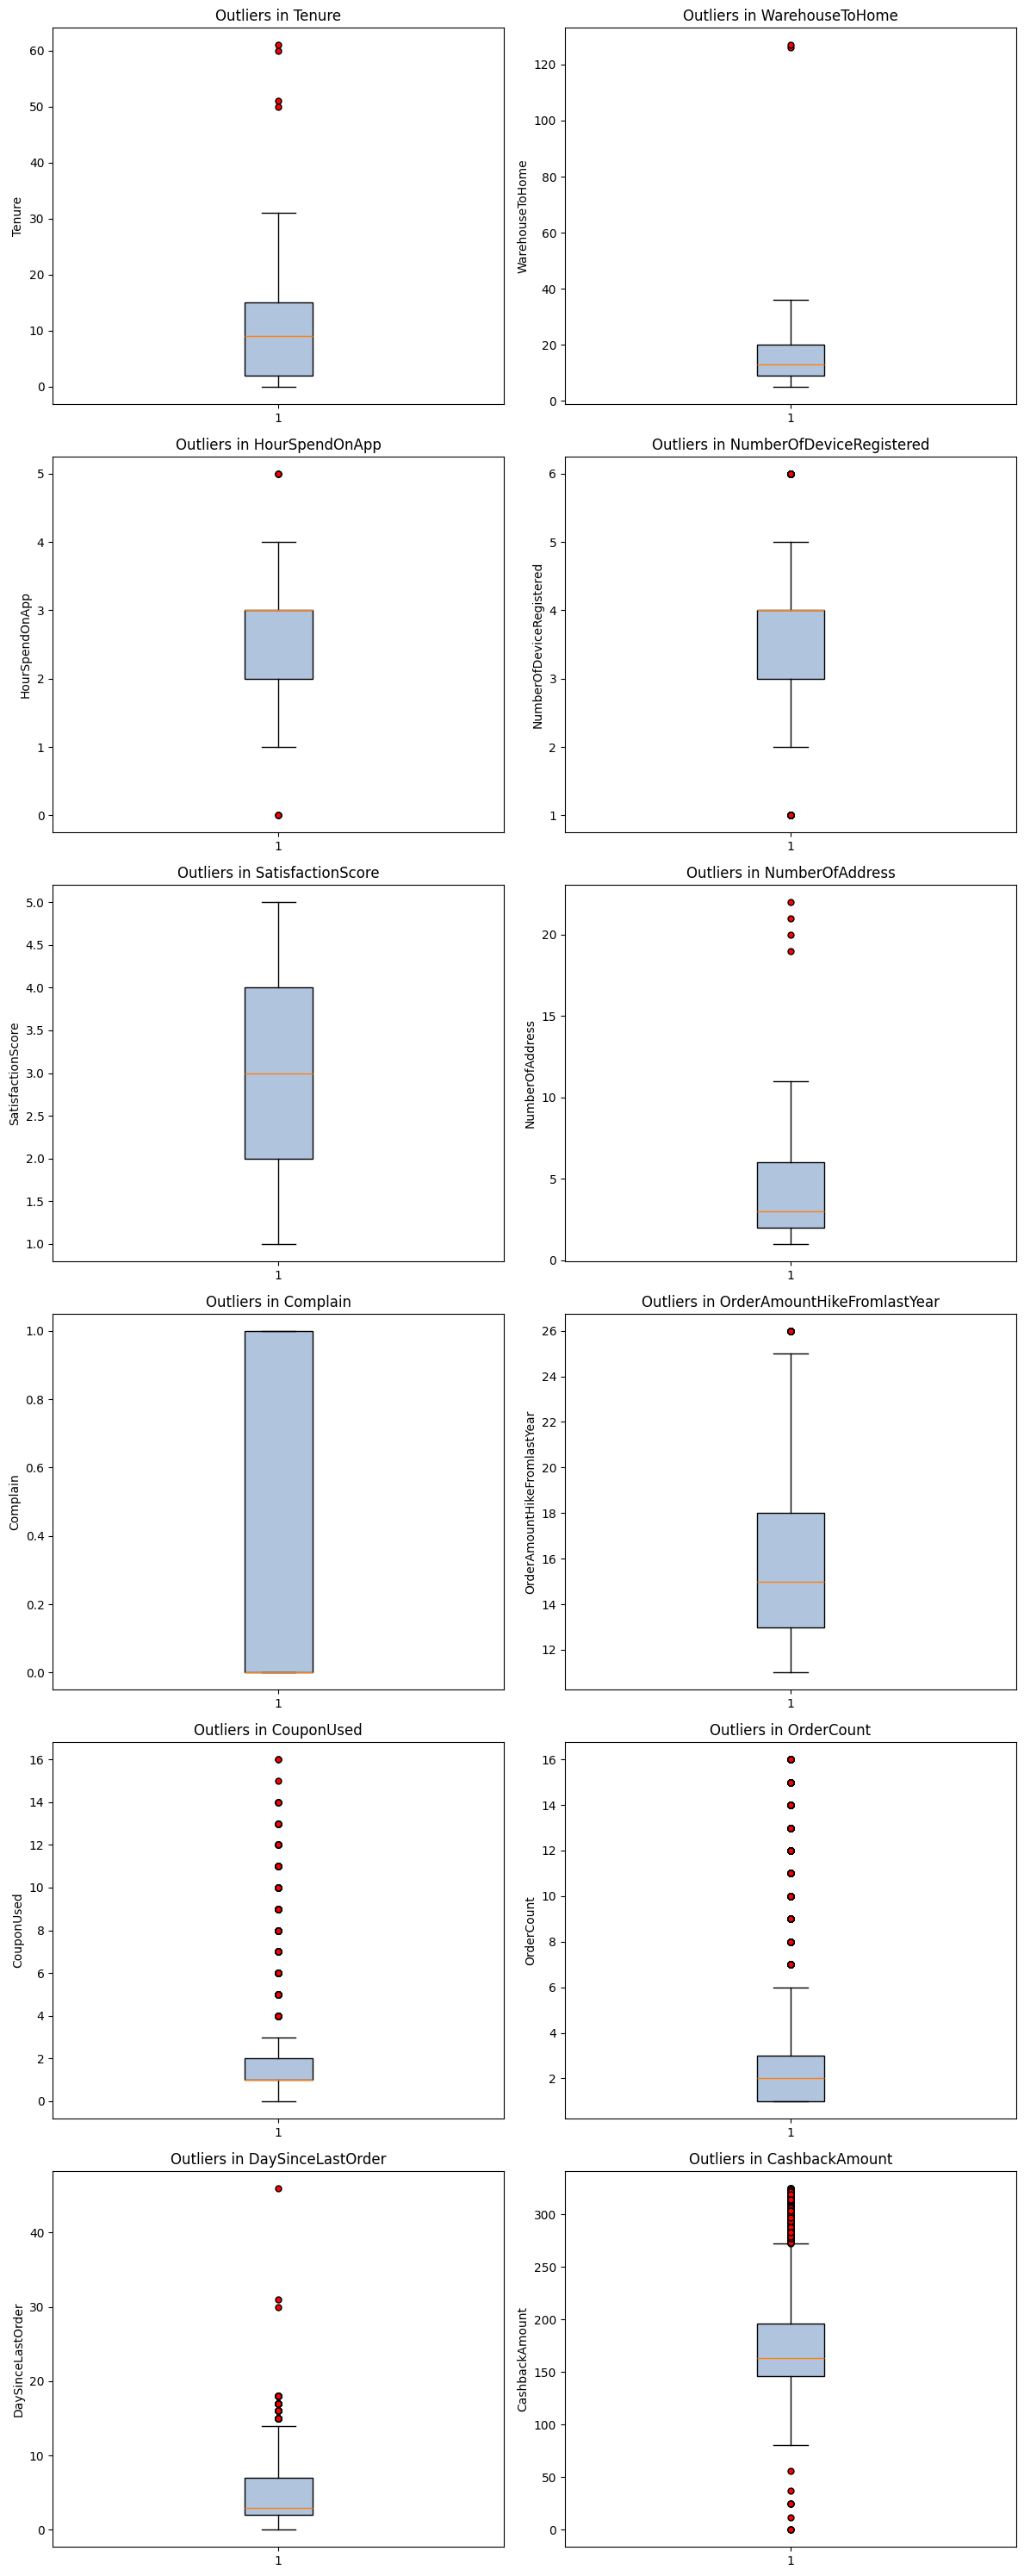

In [179]:
# Plotting Outliers

plot_outliers(df, num_columns)

Ten features have been identified as outliers, with five of them exceeding 5% of the overall dataset. If we apply the IQR method to remove these outliers, it would eliminate over 2000 entries, which constitutes half of the dataset. Because of this, removal may not be the best approach. instead, using a tree-based model could be more effective, particularly with a smaller dataset.

# 5 - Exploratory Data Analysis (EDA)

In [180]:
# Descriptive Statistics

df[['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
    'OrderAmountHikeFromlastYear', 'CouponUsed', 
    'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']].describe()

,Tenure,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000
mean,10.051510,15.552043,2.934636,15.672114,1.716874,2.961812,4.494671,177.223030
std,8.425518,8.351386,0.705528,3.591870,1.857640,2.879248,3.563632,49.207036
min,0.000000,5.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,9.000000,13.000000,3.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,15.000000,20.000000,3.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,61.000000,127.000000,5.000000,26.000000,16.000000,16.000000,46.000000,324.990000


The average `tenure` is approximately 10 months, with a range from 0 to 61 months. Customers `spend` an average of about 15.55 `hours on the app`, and the mean order amount `hike from the previous year` stands at 15.67%. On average, customers use around 2 `coupons` and place approximately 3 `orders`, with the time `since the last order` averaging 5 days. The `cashback` amount averages 177.22, indicating a significant range in customer engagement and spending habits, as reflected by the standard deviations across these metrics. 

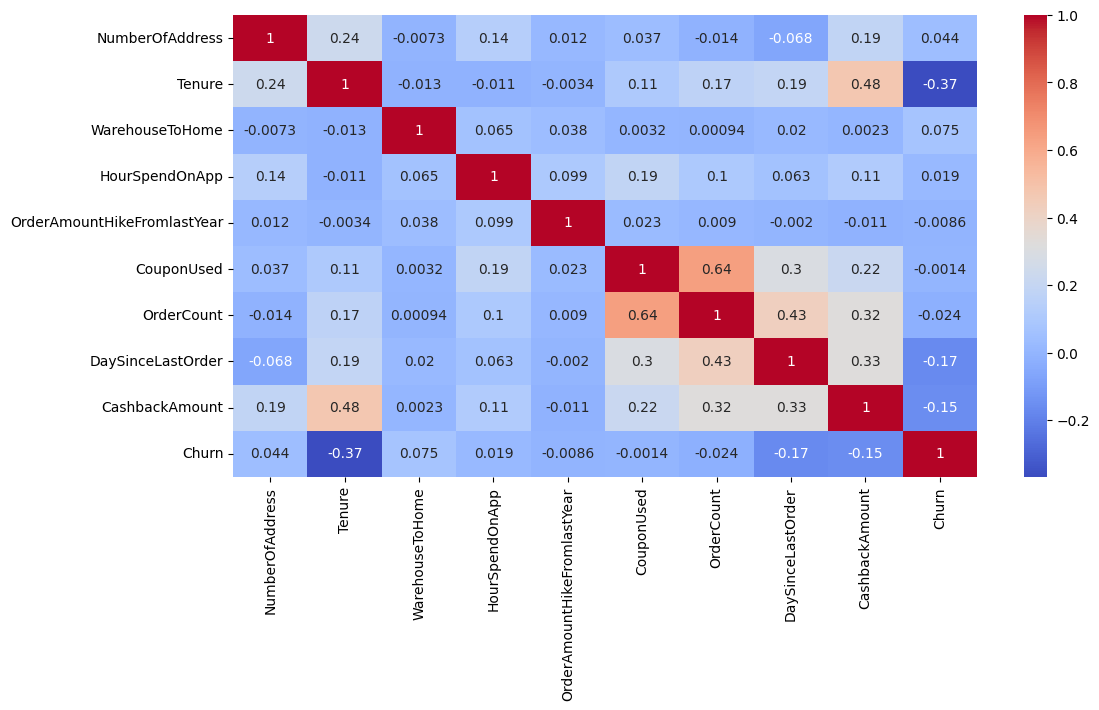

In [181]:
# heatmap correlation plotting
plt.figure(figsize=(12,6))
sns.heatmap(df[['NumberOfAddress','Tenure', 'WarehouseToHome', 'HourSpendOnApp',
                'OrderAmountHikeFromlastYear', 'CouponUsed',
                'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'Churn']].corr(), annot=True, cmap='coolwarm')
plt.show()

The correlation matrix shows a strong positive correlation exists between `Cashback Amount` and various metrics, including `Order Count` (0.32) and `Coupon Used `(0.30), suggesting that higher cashback incentives may drive increased order frequency and coupon utilization. Conversely, there is a significant negative correlation between `Churn` and `Tenure` (-0.37), indicating that longer tenured customers are less likely to churn. Additionally, `Day Since Last Order` shows a moderate positive relationship with both `Order Count` and `Cashback Amount`, implying that more frequent interactions with the app could enhance customer loyalty. Overall, leveraging cashback and coupon strategies appears vital for reducing churn and fostering sustained engagement.

### Numerical Features Analysis

In [182]:
# Function for ploting numerical features

def plot_kde_box(df, numerical_columns, churn_column):
    num_cols = len(numerical_columns)
    num_rows = (num_cols + 1) // 2 
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    
    for i, numerical_column in enumerate(numerical_columns):
        # KDE 
        sns.kdeplot(data=df, x=numerical_column, hue=churn_column, fill=True, 
                    common_norm=False, palette='coolwarm', alpha=.5, ax=axes[2 * i], linewidth=0)
        
        # median lines
        colors = sns.color_palette('coolwarm', n_colors=len(df[churn_column].unique()))
        for j, (churn_status, median_value) in enumerate(df.groupby(churn_column)[numerical_column].median().items()):
            axes[2 * i].axvline(median_value, linestyle='--', color=colors[j], 
                                 label=f'Median ({churn_column}={churn_status})')

        axes[2 * i].legend(loc='upper right')
        axes[2 * i].set_title(f'KDE Plot of {numerical_column} by {churn_column}')
        axes[2 * i].set_xlabel(numerical_column)
        axes[2 * i].set_ylabel('Density')

        # Boxplot
        sns.boxplot(data=df, x=churn_column, y=numerical_column, ax=axes[2 * i + 1], palette='coolwarm')
        axes[2 * i + 1].set_title(f'Boxplot of {numerical_column} by {churn_column}')
        axes[2 * i + 1].set_xlabel(churn_column)
        axes[2 * i + 1].set_ylabel(numerical_column)
    
    plt.tight_layout()
    plt.show()


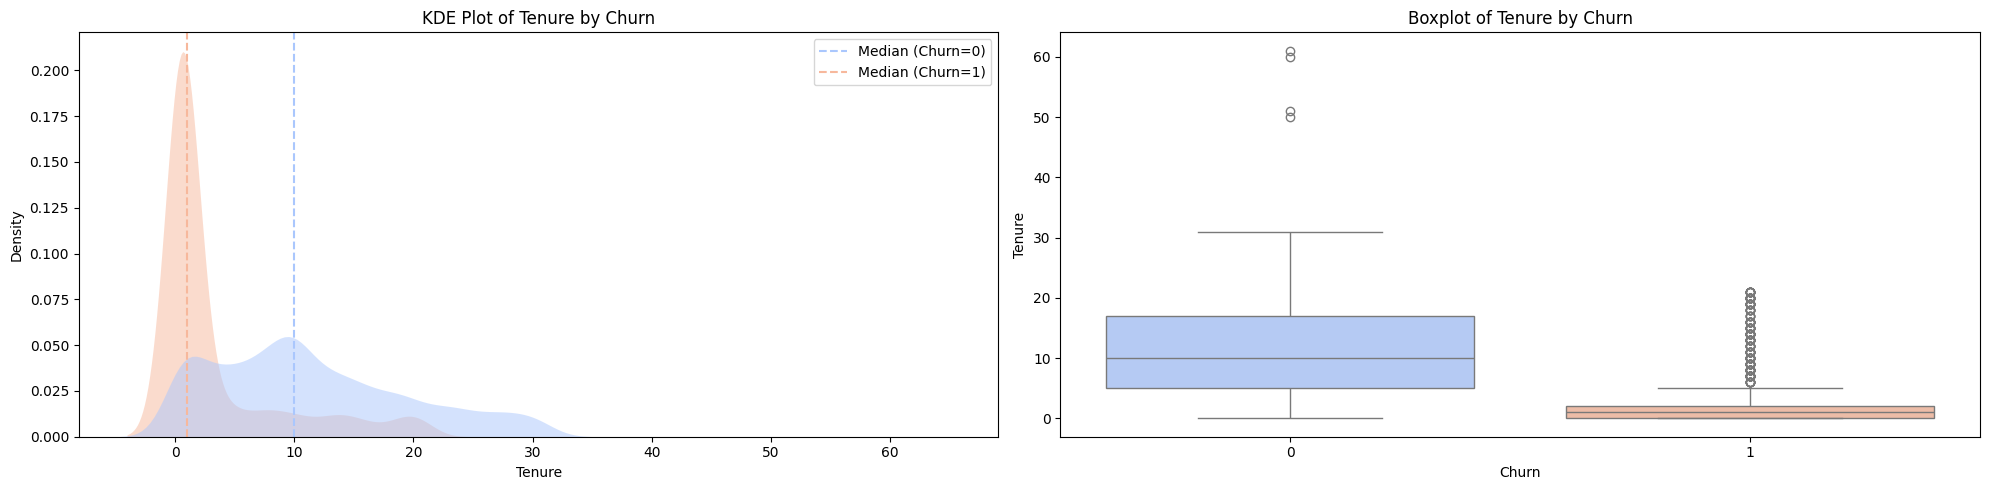

In [183]:
plot_kde_box(df, ['Tenure'], 'Churn')

Customers with lower tenure, especially those in the 1 to 6 month range, are significantly more likely to churn, as shown by the higher density of churners during this period. This shows that early-stage customers are still exploring their options and evaluating the service's value, which makes them susceptible to switching to competitors if their expectations aren't met. In contrast, non-churners tend to have a notably higher median tenure, indicating that they are generally more satisfied with their experience. A key factor influencing this behavior is cashback, which affects churn rates by around 50%. This strong relationship highlights the importance of cashback incentives in retaining customers, particularly in technology categories, where users often consider the financial benefits when making purchases. To effectively reduce churn, businesses should focus on promoting cashback offers, especially for tech products, and ensure these incentives are clearly communicated.

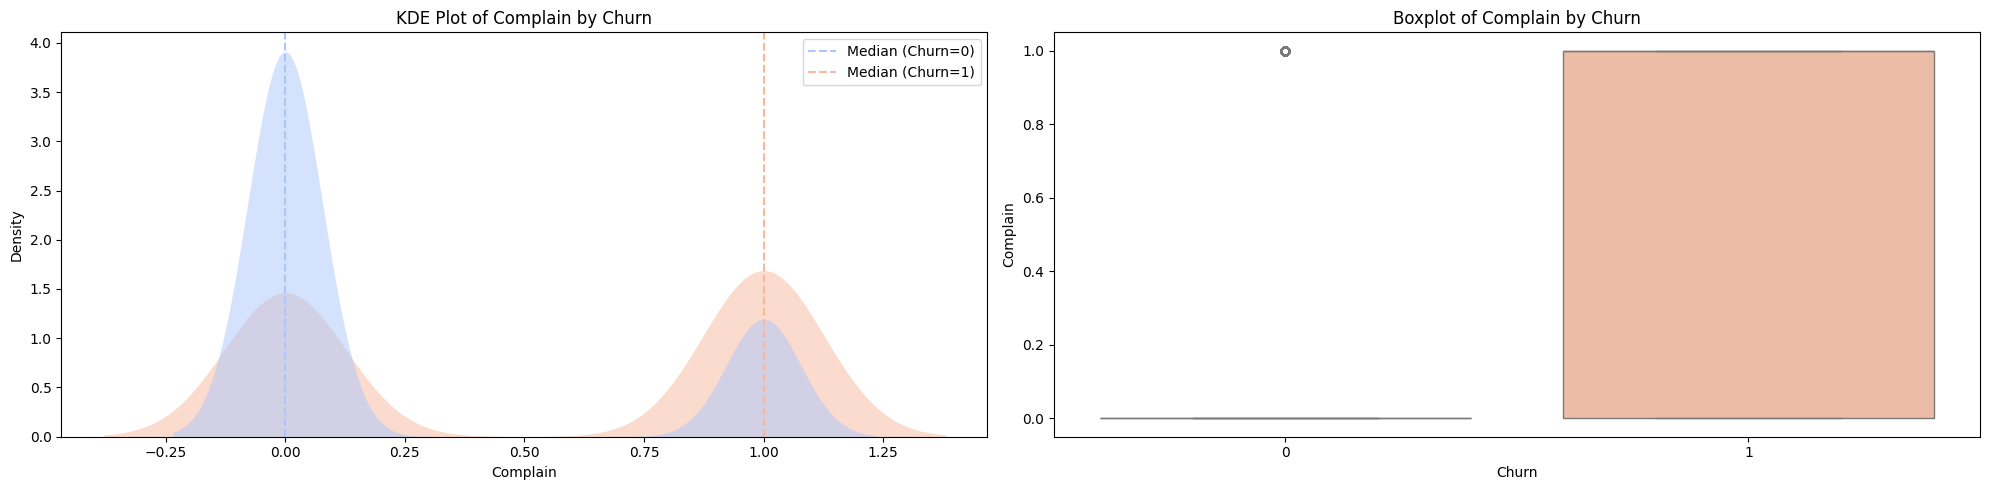

In [184]:
plot_kde_box(df, ['Complain'], 'Churn')

The KDE plot shows that non-churned customers predominantly have a Complain value near 0, indicating few or no complaints, while churned customers are mostly concentrated at Complain = 1, meaning they have filed complaints. The median lines in the KDE plot highlight this stark difference, with the median for churned customers close to 1 and for non-churned customers near 0. This pattern is reinforced by the boxplot, which shows that almost all churned customers have filed complaints, while non-churned customers rarely do. Overall, complaints are a key indicator of customer dissatisfaction, strongly associated with churn.

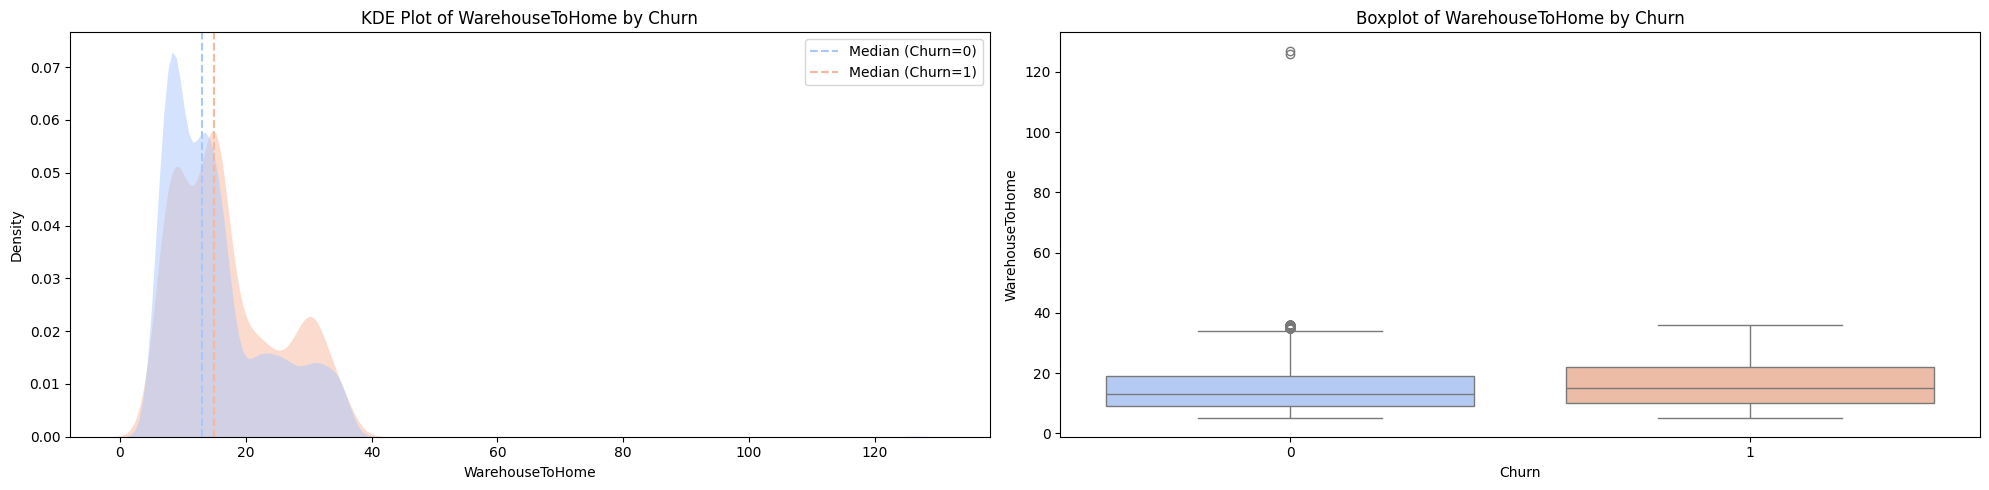

In [185]:
plot_kde_box(df, ['WarehouseToHome'], 'Churn')

Churners tend to cluster at shorter distances from the warehouse, particularly within the 0-10 unit range (km/miles), while non-churners are spread across greater distances. This indicates that customers living closer to warehouses may be more prone to churn, possibly due to higher expectations for fast delivery or a desire to see the product firsthand. Additionally, those nearby might find it easier to switch to competing options, making them more likely to leave if they perceive better deals elsewhere. In contrast, non-churners at greater distances often show stronger brand loyalty, likely because they have fewer alternatives or a deeper connection to the service. To address churn among customers near warehouses, e-commerce businesses could open physical branches or experience centers where customers can see products before purchasing. This allows them to evaluate items firsthand, ensuring they meet expectations and reducing return rates. Offering a flexible return policy for online purchases returned in-store can also enhance customer satisfaction and loyalty. This strategy not only caters to local customers’ needs but also strengthens the brand’s connection with them.

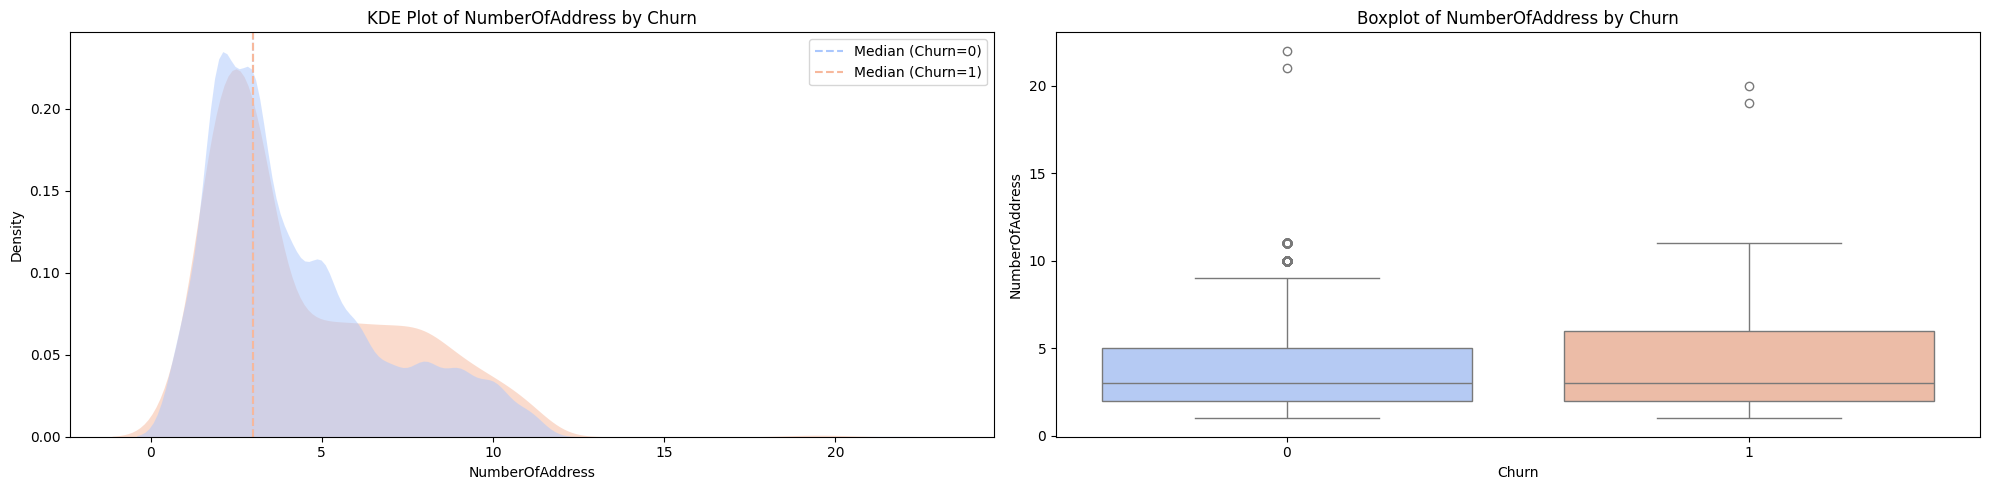

In [186]:
plot_kde_box(df, ['NumberOfAddress'], 'Churn')

Most customers have between 2 and 3 registered addresses, with 1,369 customers having 2 addresses and 1,278 having 3. As the number of addresses increases, the total count decreases, with very few customers having 10 or more addresses. This suggests that most users prefer to maintain a moderate number of addresses, typically between 1 and 5. Several factors could explain this, such as accommodating different living situations—like a primary residence, vacation home, or business location. However, according to WareHousetoHome, customers with more than 5 registered addresses are more likely to churn. This may indicate that these customers are registering multiple addresses to find the best deals, particularly regarding cheaper delivery services, or they could be seeking the optimal place to make their orders.

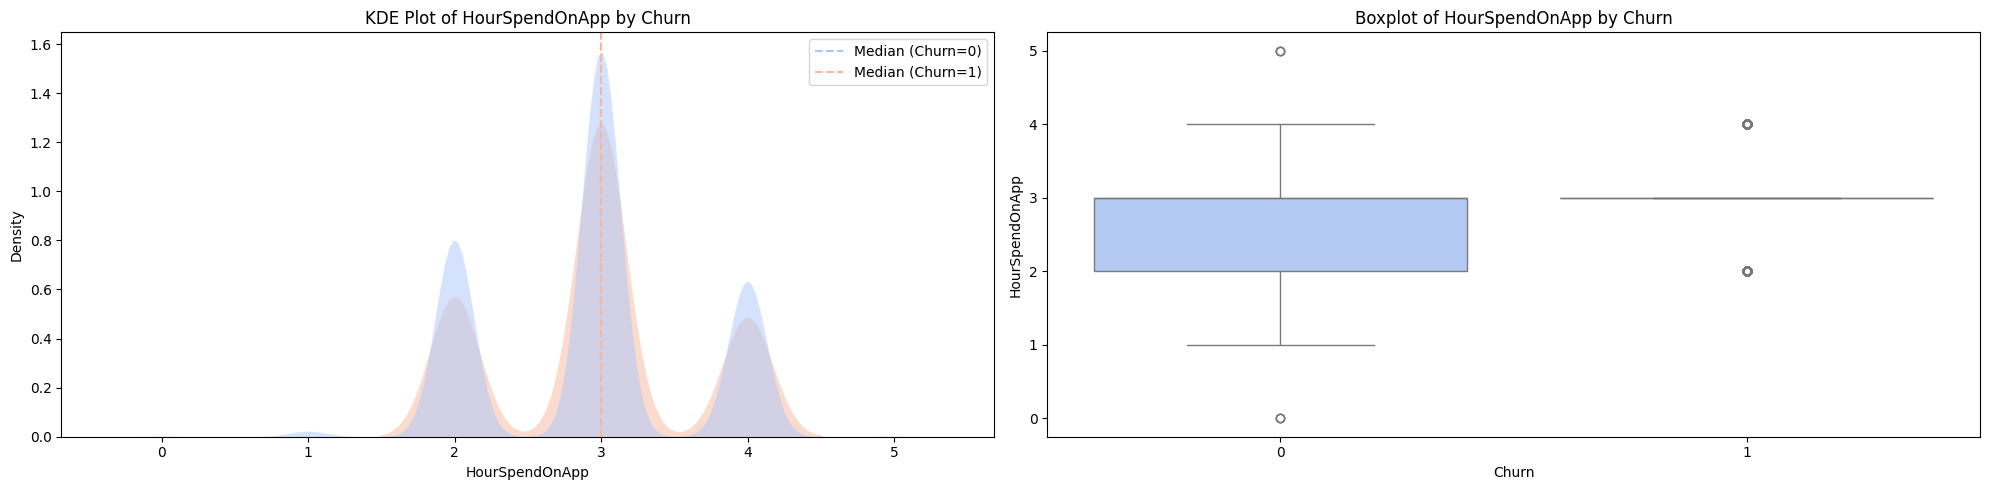

In [187]:
plot_kde_box(df, ['HourSpendOnApp'], 'Churn')

Both churners and non-churners tend to spend less time on the app, with a peak usage around 3 hours. This indicates that regardless of their loyalty status, customers may have similar engagement levels with the app, which could suggest a need for improved user experience or features that encourage longer interaction times. Enhancing the app’s functionality and content could help increase customer engagement, potentially reducing churn rates and fostering greater loyalty among users.

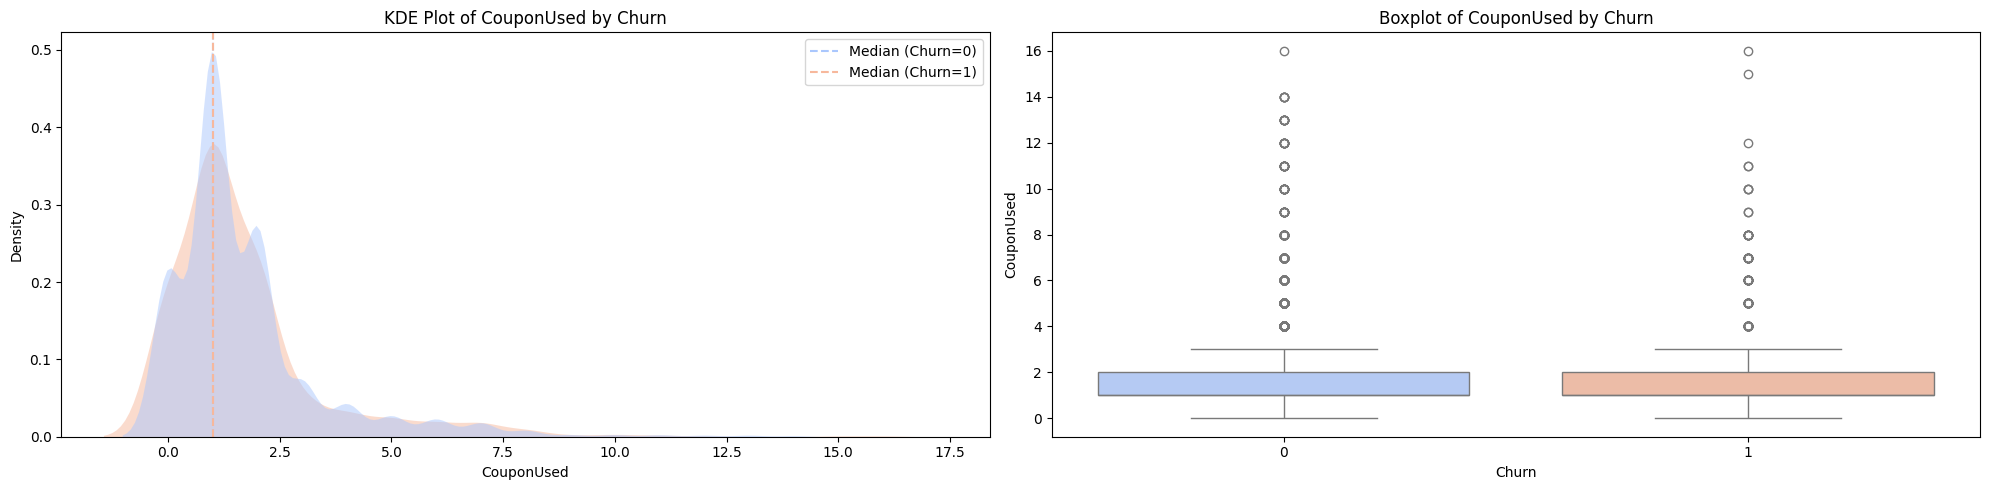

In [188]:
plot_kde_box(df, ['CouponUsed'], 'Churn')

The distribution of `CouponUsed` based on churn status shows that non-churned customers (Churn = 0), there is a higher frequency of coupon usage, particularly at lower values, with 844 customers using no coupons peak at using 1-2 coupons and gradually decreasing counts as coupon usage increases. In contrast, churned customers (Churn = 1) show significantly lower usage across all coupon counts, with only 186 customers not using any coupons and a more pronounced drop-off in frequency as the number of coupons increases. This shows that non-churned customers tend to engage more with coupon offers, which may indicate a positive relationship between coupon usage and customer retention. The stark difference in usage patterns implies that coupon engagement could be a critical factor influencing customer loyalty. 

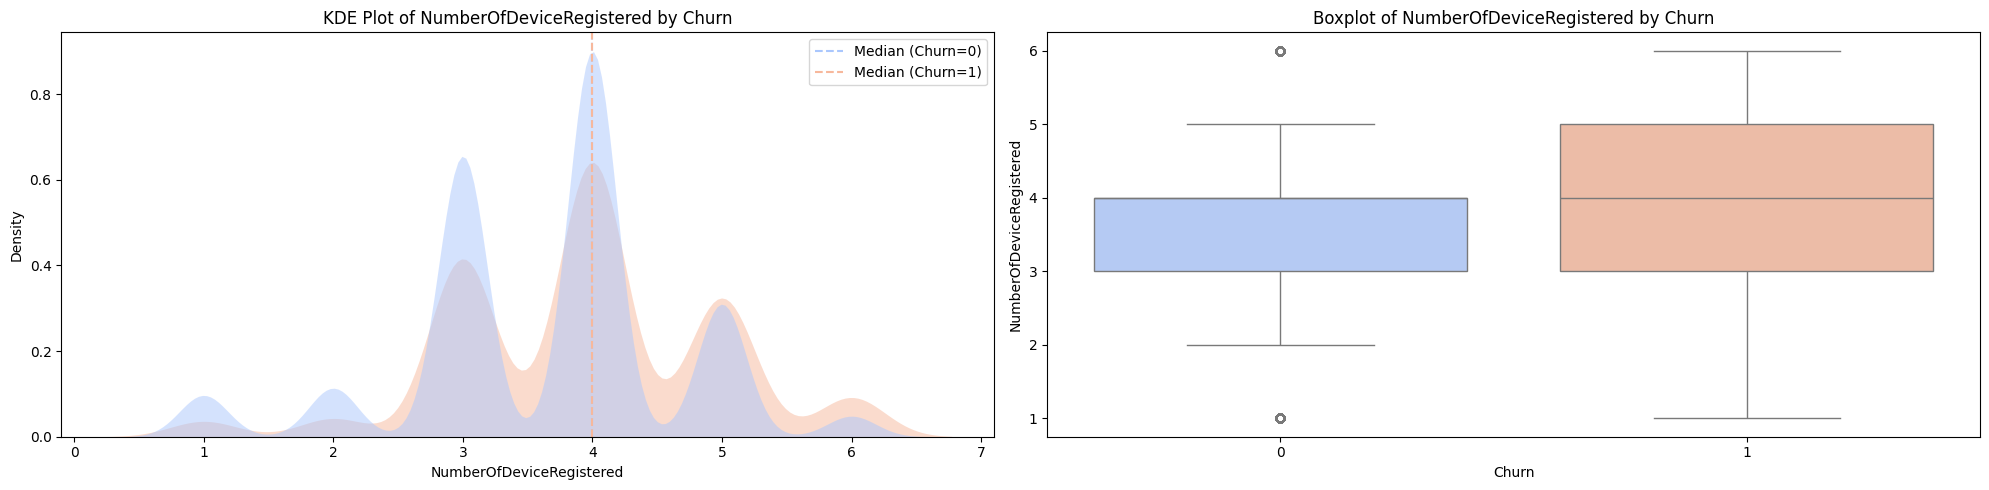

In [189]:
plot_kde_box(df, ['NumberOfDeviceRegistered'], 'Churn')

Both churners and non-churners commonly register fewer devices, typically ranging from 3 to 5, with 4 devices being the most frequent. This limited device usage may correlate with the average time spent on the app, which is around 3 hours. During this time, users likely spend significant portions scrolling to find the best matches in various categories and consider to make purchases or not.

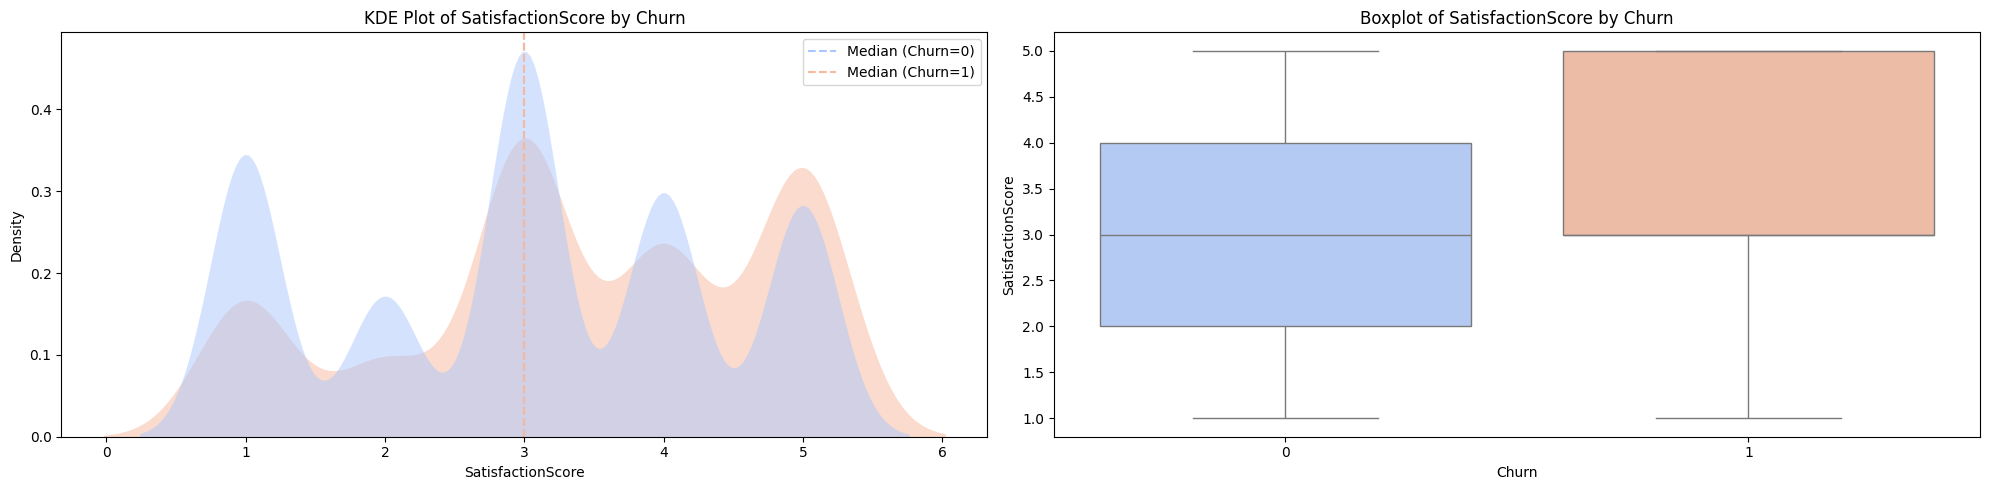

In [190]:
plot_kde_box(df, ['SatisfactionScore'], 'Churn')

Churners tend to have lower satisfaction scores, peaking around 3, while non-churners generally fall within higher scores, with a peak between 3 and 4. Interestingly, non-churners also show a notable concentration at the 1 score, indicating they might face issues with the service yet still choose to remain loyal. This presents a paradox: while higher satisfaction is associated with lower churn rates, loyal customers can still experience significant dissatisfaction. To improve retention, it's essential to identify the specific factors contributing to this dissatisfaction among non-churners to retain customers.


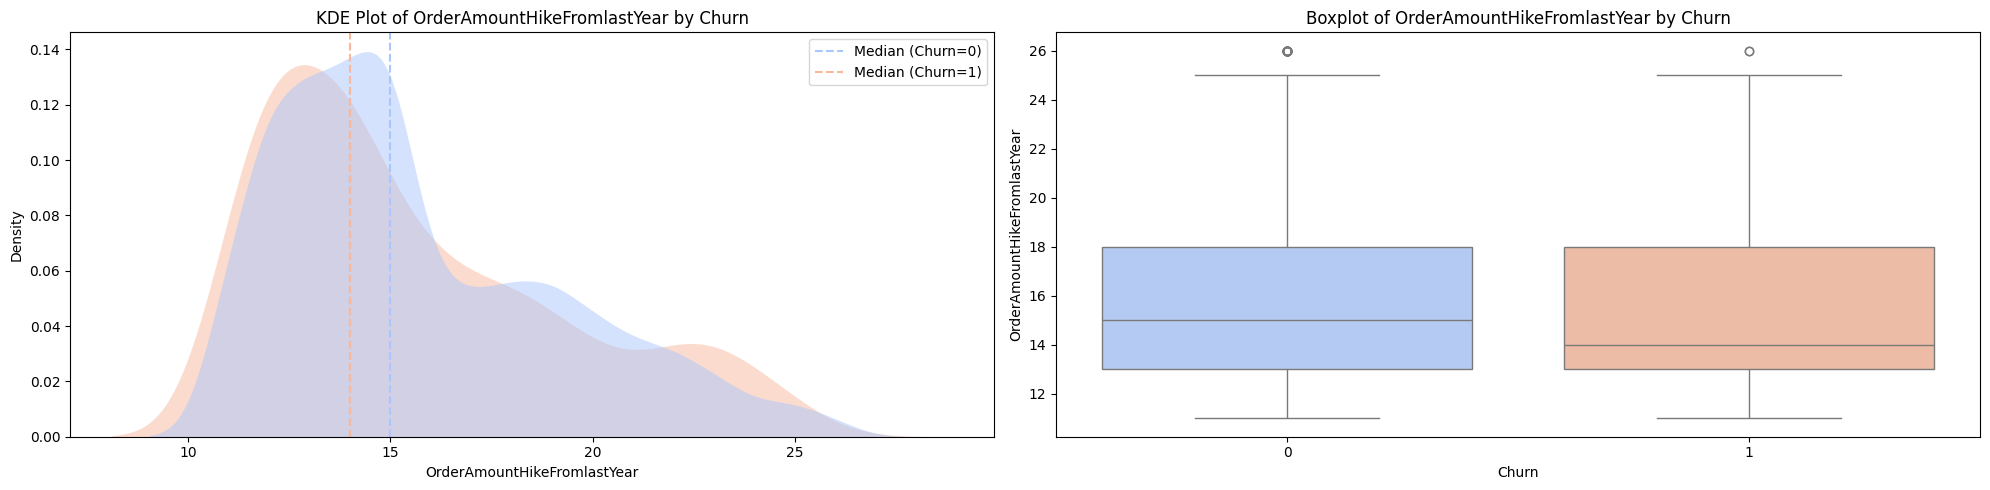

In [191]:
plot_kde_box(df, ['OrderAmountHikeFromlastYear'], 'Churn')

This disparity of Order Amount that customers who experience greater order amount hikes from the previous year are less likely to churn, indicating a potential correlation between increased spending and customer retention.

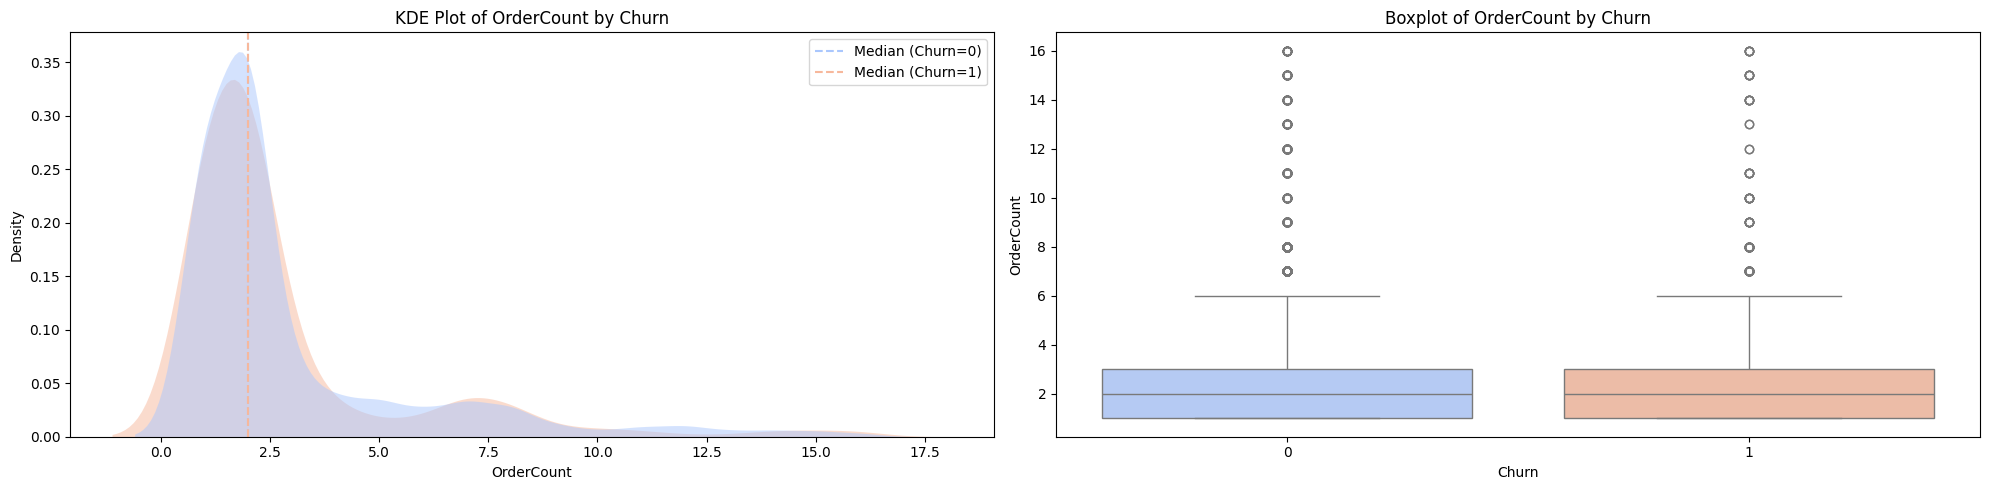

In [192]:
plot_kde_box(df, ['OrderCount'], 'Churn')

Whether it's for churned customers or those who haven't churned, the distribution of `OrderCount` shows a concentration around 1 to 2 orders. This indicates that a significant portion of both groups has a low engagement level, suggesting that many customers may not be utilizing the service frequently. This trend could imply that increasing the number of orders might be a potential area for improving customer retention and overall satisfaction. Additionally, the sharp drop in frequency as the `OrderCount` increases highlights a challenge in converting first-time or occasional users into regular customers. Filling the missing values in the `OrderCount` feature with the median is a suitable approach, as it helps fill in gaps and lead more balanced dataset.

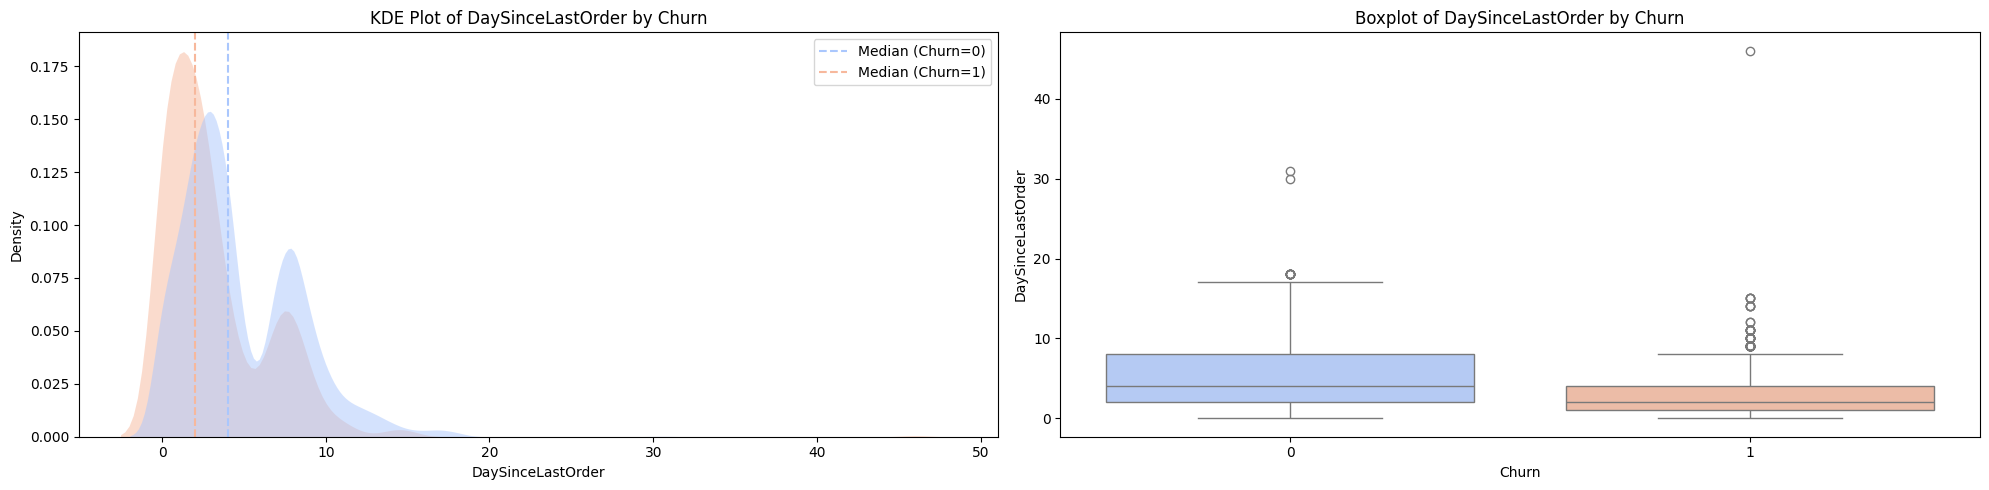

In [193]:
plot_kde_box(df, ['DaySinceLastOrder'], 'Churn')

Customers who churn typically have longer gaps since their last order, peaking around 7-10 days, while non-churners show shorter intervals between purchases. This suggests that consistent engagement through regular orders can help reduce churn. To enhance retention, businesses could implement personalized product recommendations adjusted to individual interests. For instance, if a customer previously purchased a laptop, offering relevant accessories to complement their previous purchases could encourage further engagement and increase the likelihood of repeat purchases.

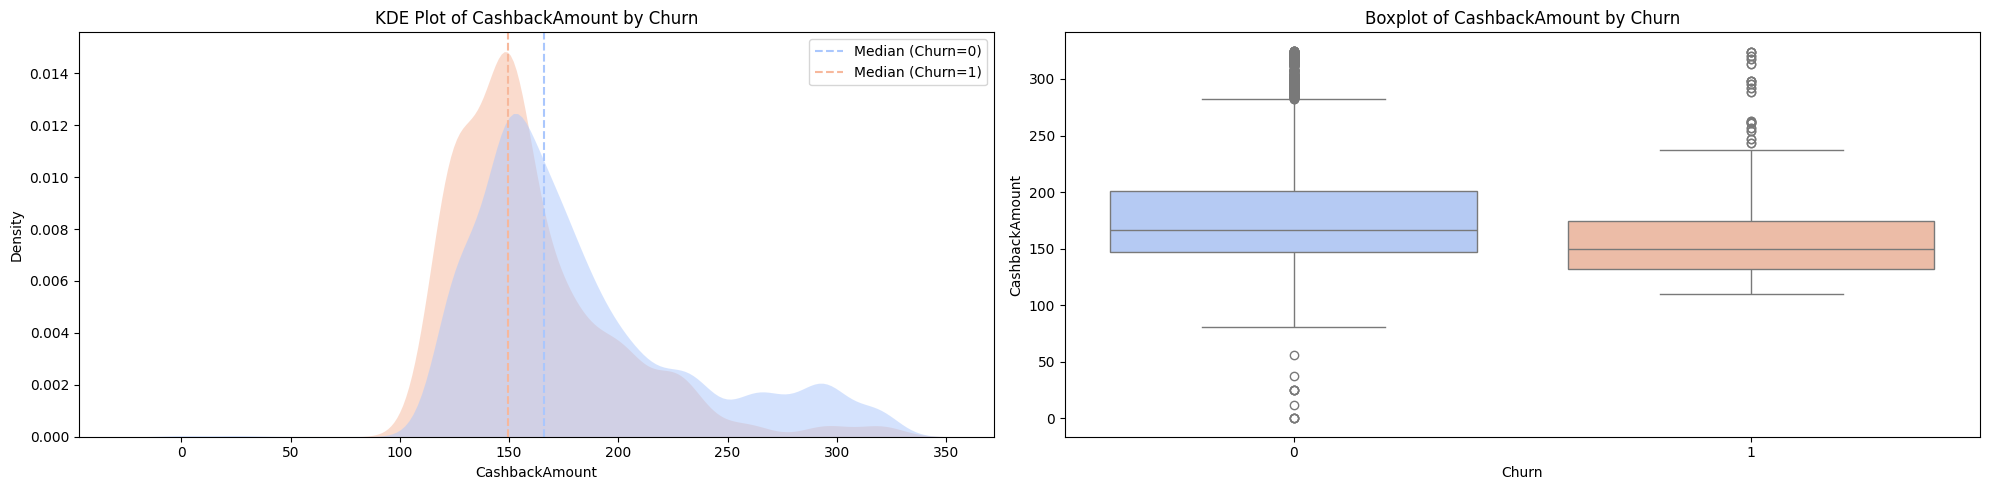

In [194]:
plot_kde_box(df, ['CashbackAmount'], 'Churn')

Churners generally receive lower cashback amounts, averaging around $100, while non-churners get a wider range, often exceeding $150. The negative correlation of -0.17 suggests that as cashback amounts increase, the likelihood of churn decreases. This implies that offering higher cashback incentives could help improve customer retention. However, it's crucial to evaluate how adjusting cashback affects the business overall. Collaborating with the risk pricing department to analyze potential risks associated with these changes will be important to ensure that increasing cashback doesn't negatively impact profitability company.

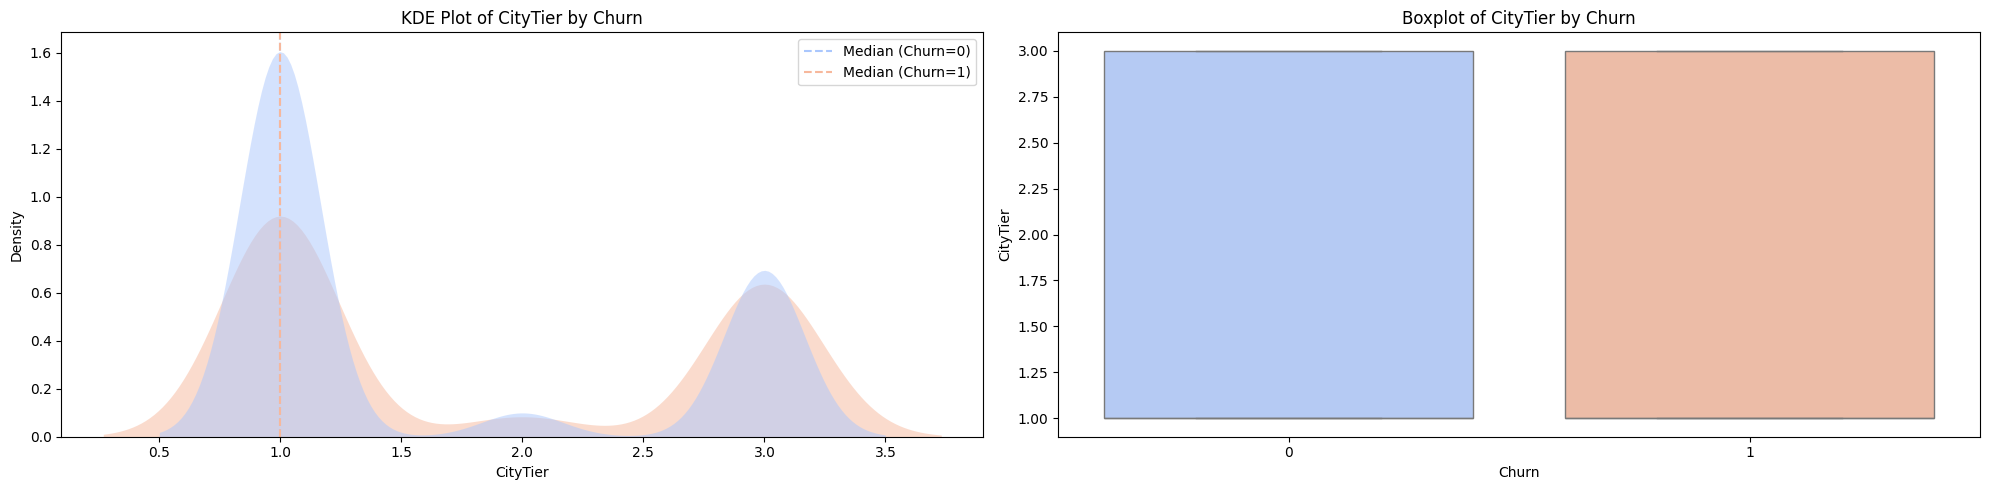

In [195]:
plot_kde_box(df, ['CityTier'], 'Churn')

PENJELASAn

In [196]:

def plot_box(df, numerical_columns, churn_column):
    num_cols = len(numerical_columns)
    num_rows = (num_cols + 1) // 3 
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    
    for i, numerical_column in enumerate(numerical_columns):
        sns.boxplot(data=df, x=churn_column, y=numerical_column, ax=axes[i], palette='coolwarm')
        axes[i].set_title(f'Boxplot of {numerical_column} by {churn_column}')
        axes[i].set_xlabel(churn_column)
        axes[i].set_ylabel(numerical_column)

    for j in range(num_cols, num_rows * 3):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()



**Top features that show distinct characteristics for churn (Churn=1)**

`Tenure`:
The boxplot shows a significant difference in tenure between churned (1) and non-churned (0) customers. Churned customers have much lower tenure, with many close to 0, while non-churned customers have a wider range and higher median tenure. This shows that customers who stay for a shorter period are more likely to churn.

`Complain`:
almost all customers who churned have logged a complaint (represented by a value of 1), whereas non-churned customers generally have 0 complaints. This shows that customers who experience issues serious enough to file complaints are much more likely to leave.

`DaySinceLastOrder`:
The churned customers tend to have much smaller values for the number of days since their last order. The non-churned customers show a broader range of values, suggesting that churned customers typically stop ordering earlier and have shorter engagement periods.

### Categorical Features Analysis (Focus on Churn)

In [197]:
cat_columns

['PreferredLoginDevice',
 'PreferredPaymentMode',
 'Gender',
 'Complain',
 'PreferedOrderCat',
 'MaritalStatus']

In [198]:
# Function for ploting categorical features

def plot_categorical(df, categorical_columns, churn_column):
    fig, axes = plt.subplots(1, len(categorical_columns) + 2, figsize=(18, 6))

    for ax, col in zip(axes[:-2], categorical_columns):
        sns.countplot(data=df, x=col, hue=churn_column, palette='coolwarm', ax=ax)
        ax.set_title(f'Count of {col} by {churn_column}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility

    churn_data = df[df[churn_column] == 1]
    churn_counts = churn_data[categorical_columns[0]].value_counts()
    
    axes[-2].pie(churn_counts, 
                  labels=churn_counts.index, 
                  autopct='%1.1f%%', startangle=90, 
                  colors=sns.color_palette('coolwarm', len(churn_counts)))
    axes[-2].set_title(f'Ratio of {categorical_columns[0]} in Churn')
    
    non_churn_data = df[df[churn_column] == 0]
    non_churn_counts = non_churn_data[categorical_columns[0]].value_counts()
    
    axes[-1].pie(non_churn_counts, 
                  labels=non_churn_counts.index, 
                  autopct='%1.1f%%', startangle=90, 
                  colors=sns.color_palette('coolwarm', len(non_churn_counts)))
    axes[-1].set_title(f'Ratio of {categorical_columns[0]} in Non-Churn')

    plt.tight_layout()
    plt.show()


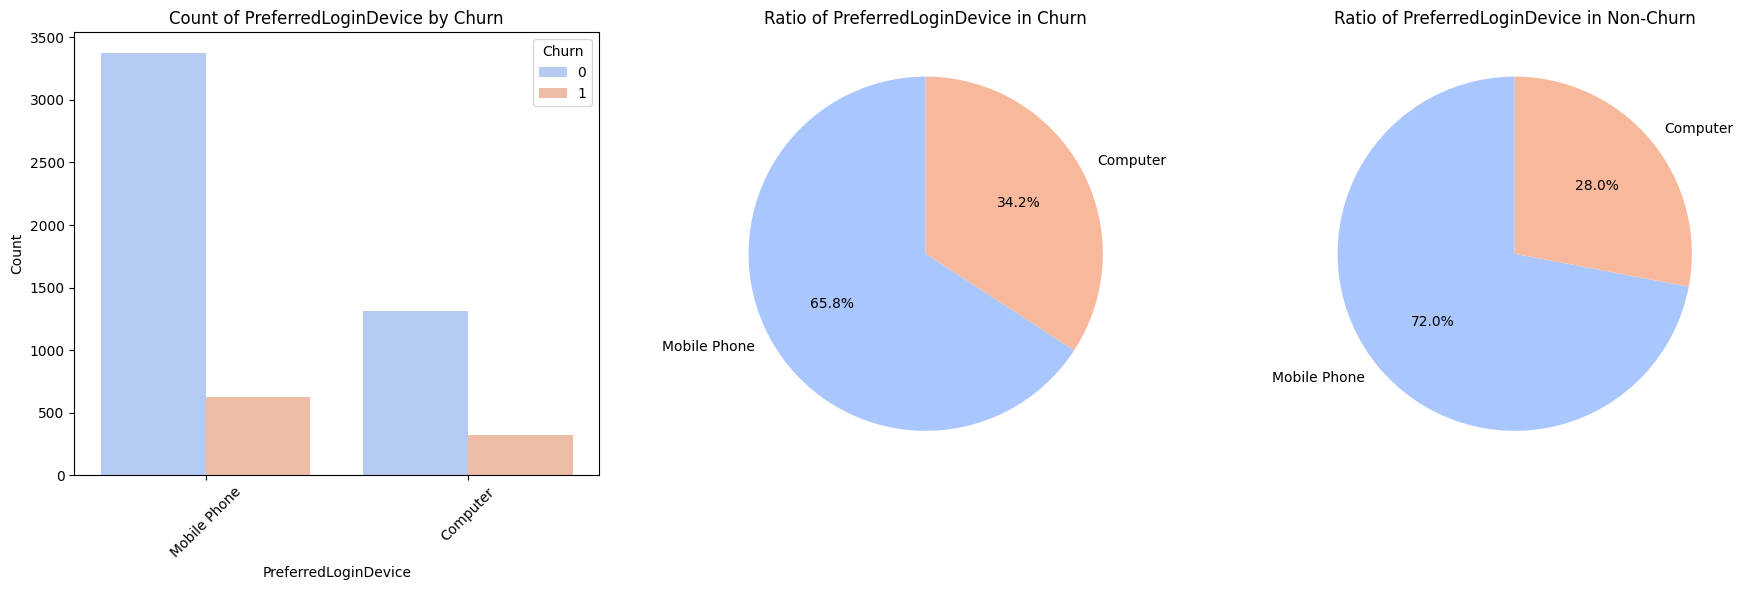

In [199]:
plot_categorical(df, ['PreferredLoginDevice'], 'Churn')

Computer users have a churn rate of 34.2% and a non-churn rate of 28%, while mobile phone users experience a much higher churn rate of 65.8% and a non-churn rate of 72.0%. Although computer users have a notable churn rate, mobile phone users exhibit a churn rate that is nearly double that of computer users. This is could be the behavior of mobile users. People tend to check their phones frequently throughout the day—when they wake up, during breaks, and in various downtime moments. This constant engagement encourages quick and impulsive decision-making, making purchases through mobile phones more common.

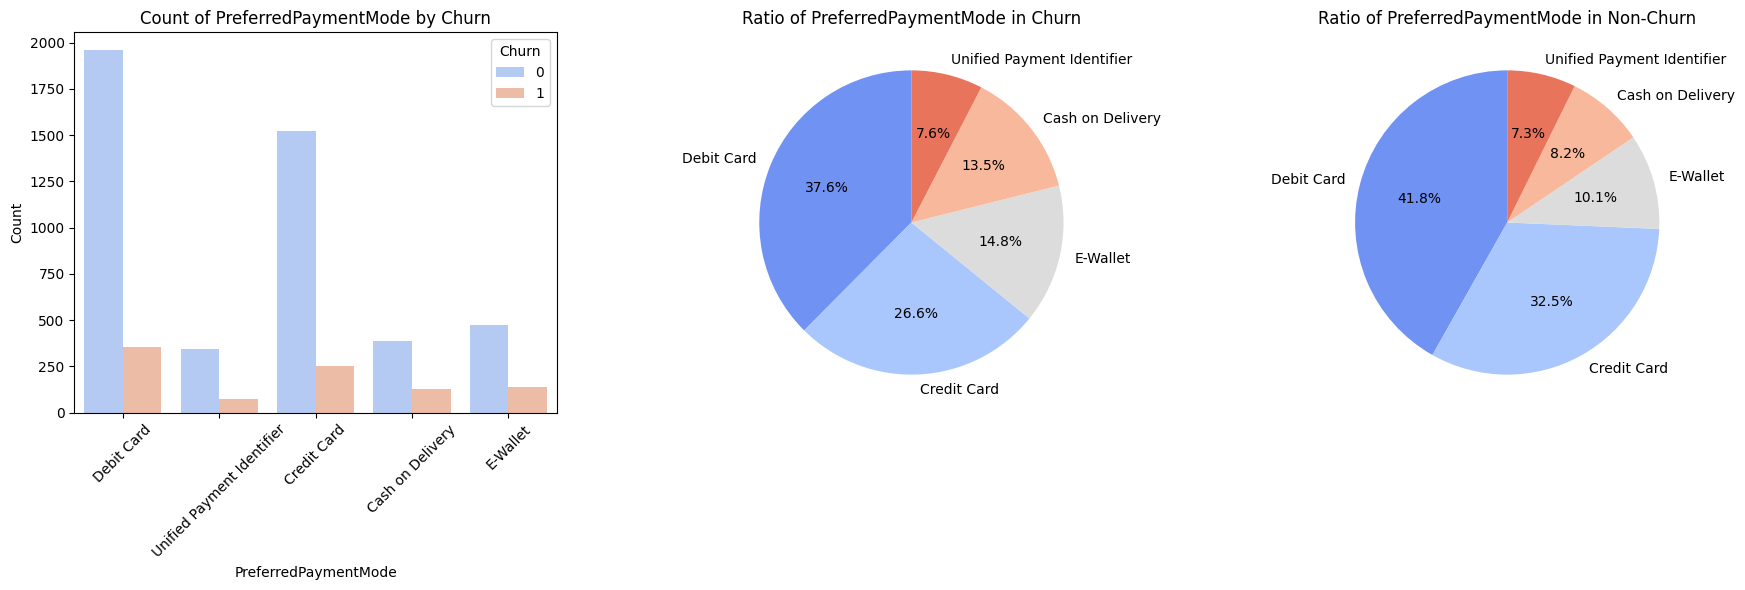

In [200]:
plot_categorical(df, ['PreferredPaymentMode'], 'Churn')

Customers using debit payment methods—such as Debit Cards, E-Wallets, and Cash on Delivery—exhibit churn rates approximately 4% higher than their non-churners. This is because among those with lower tenure, especially within the 1 to 6 month range, where early-stage customers are more likely to churn as they explore their options and evaluate the service's value. In contrast, Credit Card users show a smaller churn impact of about 6% overall.Non-churners, on the other hand, tend to have a significantly higher median tenure, indicating greater satisfaction with their experiences. This suggests that payment method and tenure are closely linked, with early-stage customers using debit options being more vulnerable to churn.

In [201]:
df.Gender.value_counts()

Gender
Male      3384
Female    2246
Name: count, dtype: int64

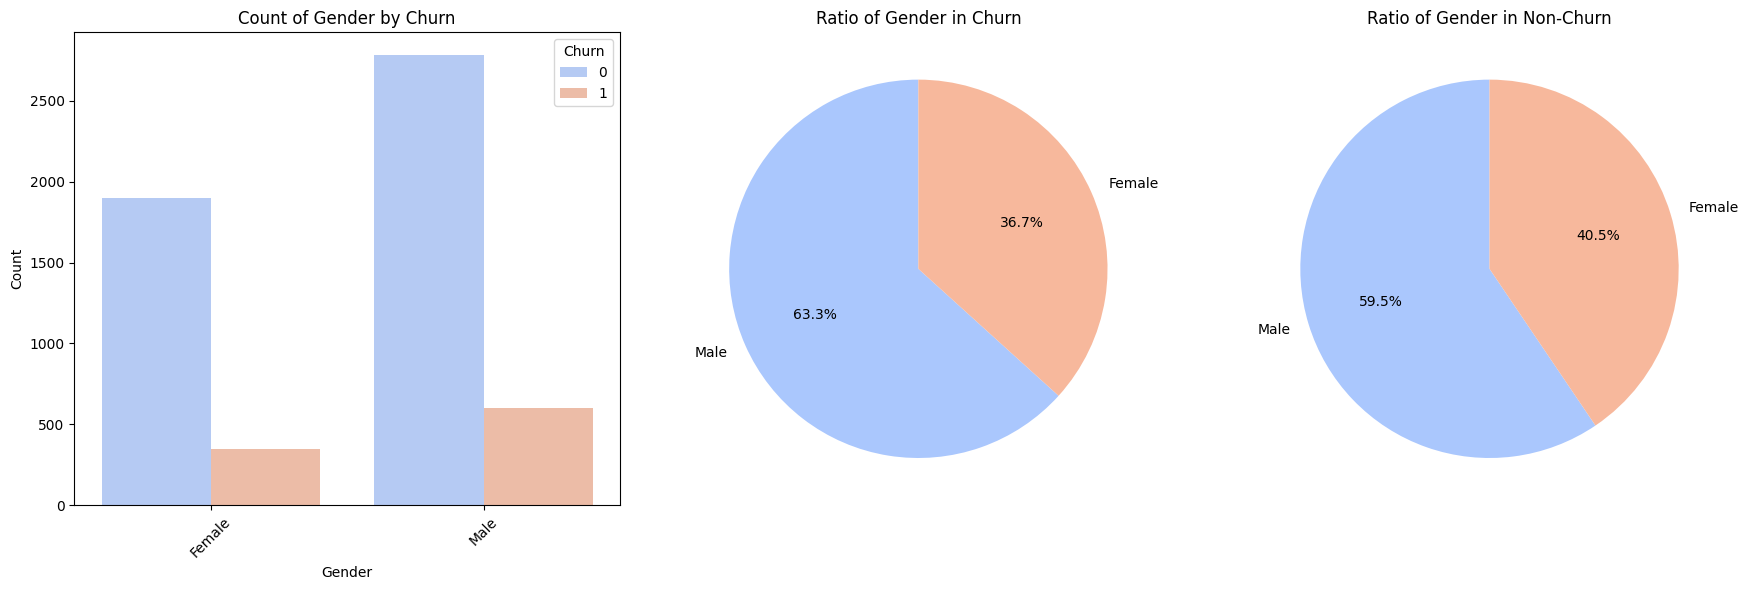

In [202]:
plot_categorical(df, ['Gender'], 'Churn')

Since the proportions of female and male customers are not balanced in our dataset, it is likely that males comprise the majority of both churned and non-churned customers.

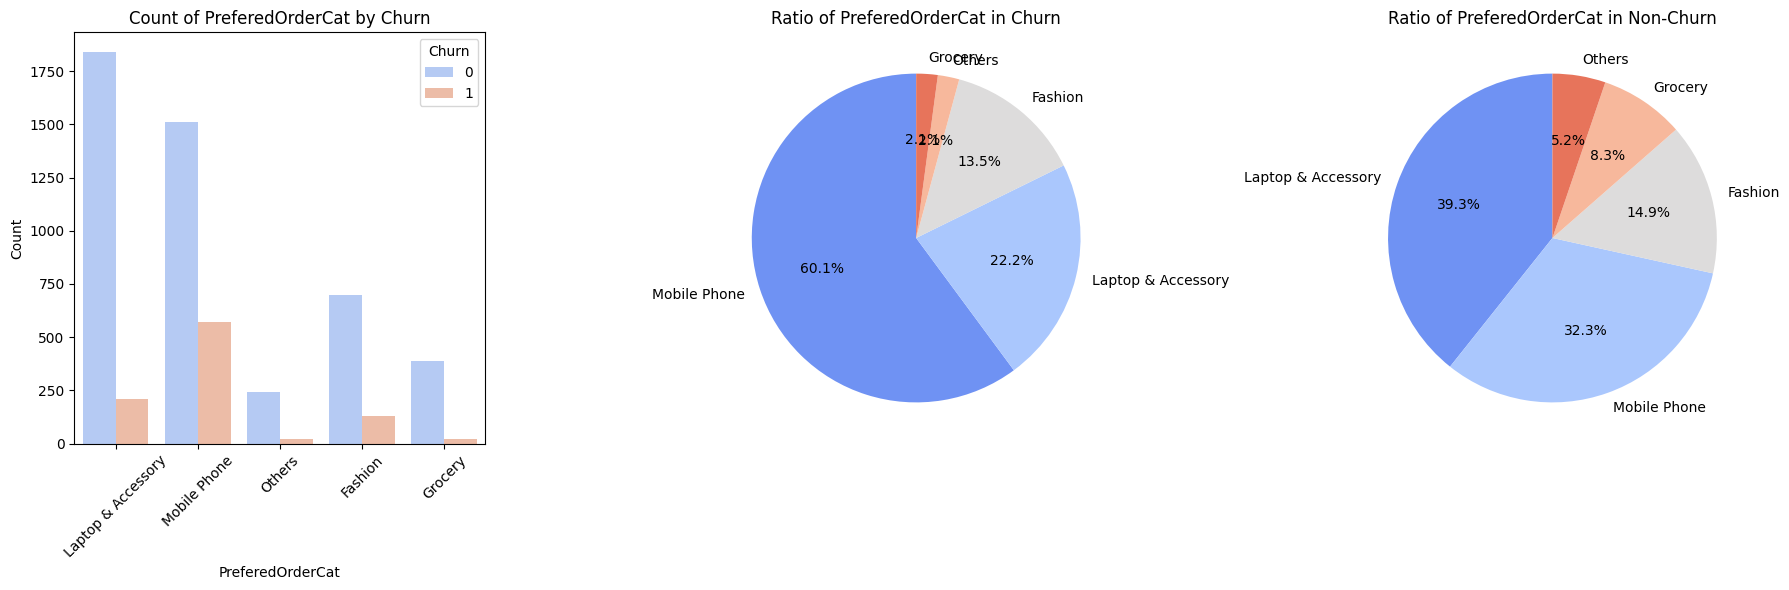

In [203]:
plot_categorical(df, ['PreferedOrderCat'], 'Churn')

When comparing churned and non-churned customers, it's interesting to note that mobile phone users account for approximately 60% of total churn, which is double the 30% among non-churned customers. This shows that the primary trigger for churn is largely driven by mobile phone customers.

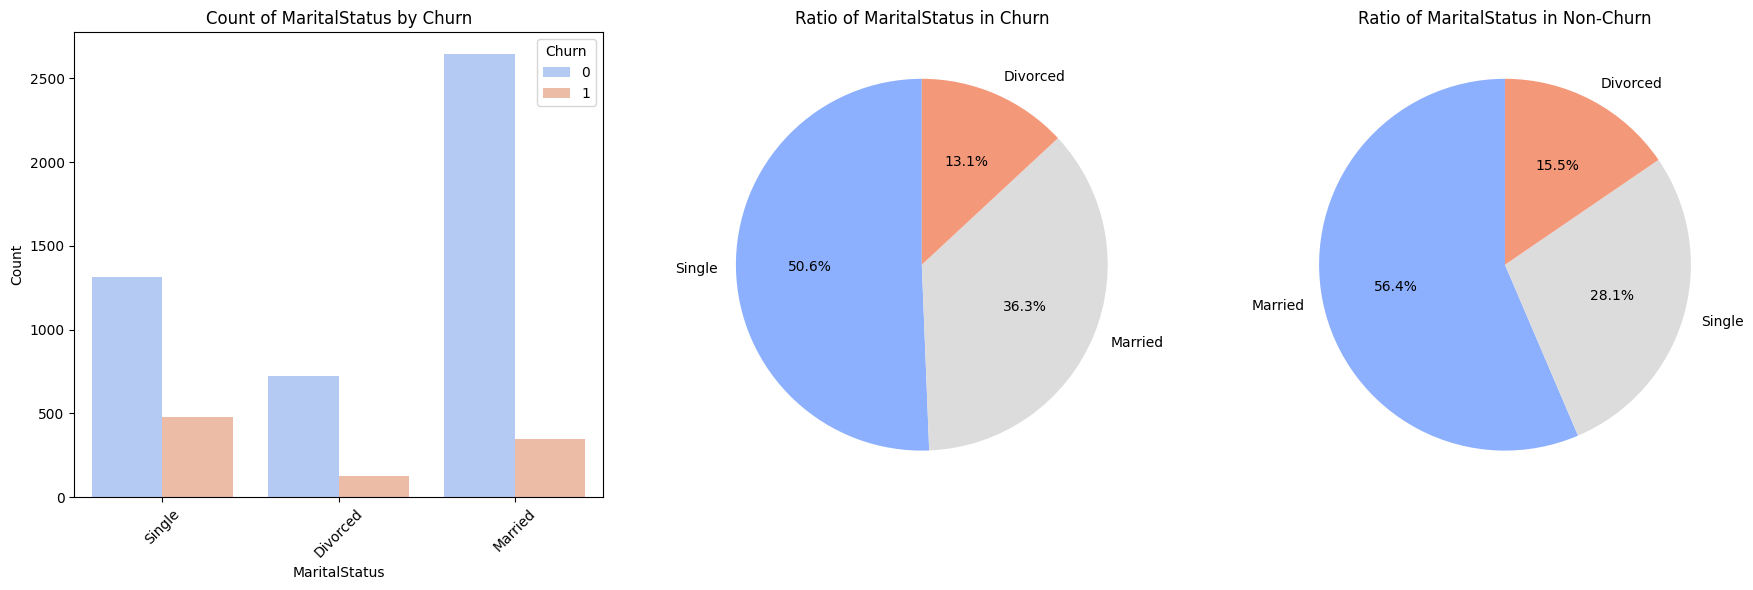

In [204]:
plot_categorical(df, ['MaritalStatus'], 'Churn')

Analysis of marital status reveals that the majority of churn is attributed to single users, who account for approximately 50.6%, followed by married individuals at around 36.3%. This is in stark contrast to non-churn customers where the majority is married about 56% and single 30% from total.

In [205]:
# Function table proportion of top 3 for churn and non churn
def calculate_churn_proportions(df, column1, column2, churn_column):
    count = df.groupby([column1, column2, churn_column])[churn_column].count().unstack(fill_value=0)
    count['Proportion_Churn'] = count[1] / count[1].sum()
    count['Proportion_NonChurn'] = count[0] / count[0].sum()
    count['difference'] = count['Proportion_Churn'] - count['Proportion_NonChurn']
    
    result = count.reset_index()
    churn_results = result[[column1, column2, 'Proportion_Churn', 'Proportion_NonChurn', 'difference']].sort_values(by='Proportion_Churn', ascending=False).head(3)
    nonchurn_results = result[[column1, column2, 'Proportion_Churn', 'Proportion_NonChurn', 'difference']].sort_values(by='Proportion_NonChurn', ascending=False).head(3)
    
    return churn_results, nonchurn_results

In [206]:
# Visualization of top 3 for churn and non churn
def plot_churn_and_nonchurn(churn_results, nonchurn_results, column1, column2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    churn_results['Label'] = churn_results[column1] + ' (' + churn_results[column2] + ')'
    x_churn = range(len(churn_results))
    
    # Churn visualization
    axes[0].bar(x_churn, churn_results['Proportion_Churn'], 
                color=sns.color_palette('coolwarm', 2)[0], 
                alpha=0.6, label='Churn Rate', width=0.4) 

    axes[0].bar([i + 0.4 for i in x_churn], churn_results['Proportion_NonChurn'], 
                color=sns.color_palette('coolwarm', 1)[0], 
                alpha=0.6, label='Non-Churn Rate', width=0.4)
    axes[0].set_title('Top three proportion factors influencing Churn')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticks([i + 0.2 for i in x_churn])
    axes[0].set_xticklabels(churn_results['Label'], rotation=45, ha='right')
    axes[0].legend()

    # Non-Churn Visualization
    nonchurn_results['Label'] = nonchurn_results[column1] + ' (' + nonchurn_results[column2] + ')'
    x_nonchurn = range(len(nonchurn_results))
    
    axes[1].bar(x_nonchurn, nonchurn_results['Proportion_Churn'], color=sns.color_palette('coolwarm', 1)[0], alpha=0.6, label='Churn Rate', width=0.4)
    axes[1].bar([i + 0.4 for i in x_nonchurn], nonchurn_results['Proportion_NonChurn'], color=sns.color_palette('coolwarm', 2)[0], alpha=0.6, label='Non-Churn Rate', width=0.4)
    
    axes[1].set_title('Top three proportion factors influencing Non-Churn')
    axes[1].set_ylabel('Proportion')
    axes[1].set_xticks([i + 0.2 for i in x_nonchurn])
    axes[1].set_xticklabels(nonchurn_results['Label'], rotation=45, ha='right')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

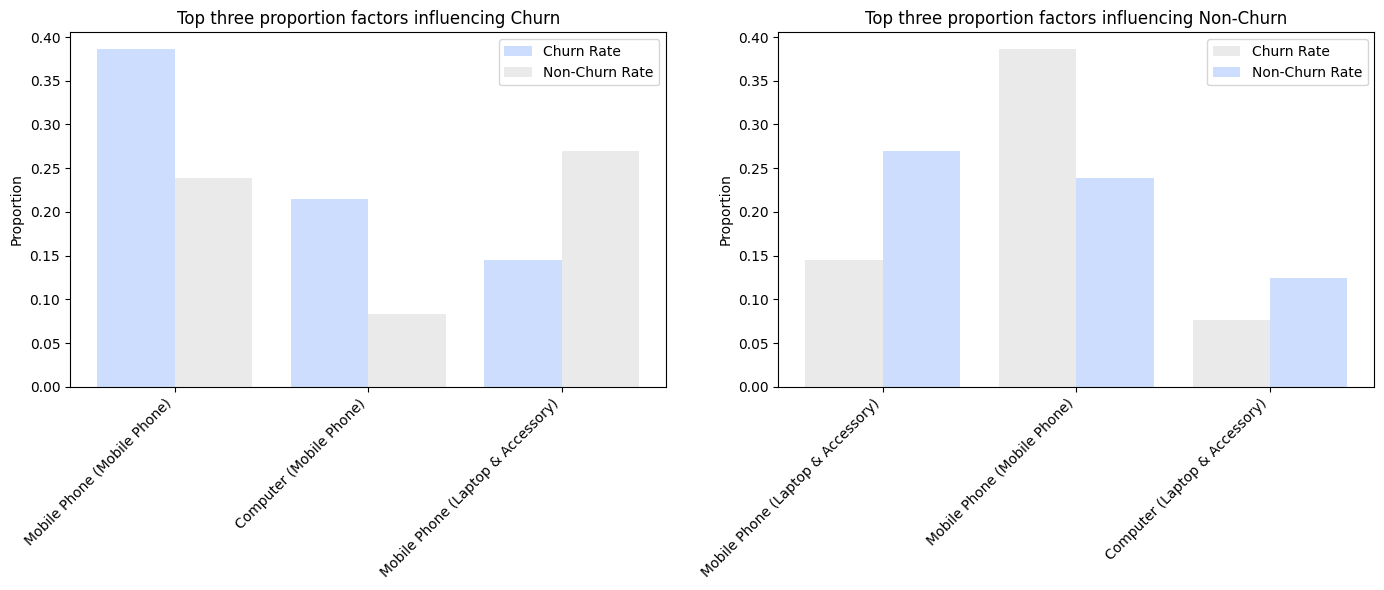

In [207]:
# PreferredLoginDevice and PreferedOrderCat towards Churn
churn_results, nonchurn_results = calculate_churn_proportions(df, 'PreferredLoginDevice', 'PreferedOrderCat', 'Churn')
plot_churn_and_nonchurn(churn_results, nonchurn_results, 'PreferredLoginDevice', 'PreferedOrderCat')

Whether customers use mobile phones or computers on our app, a smiliarity is that those buying mobile phones have churn rates above 50%.

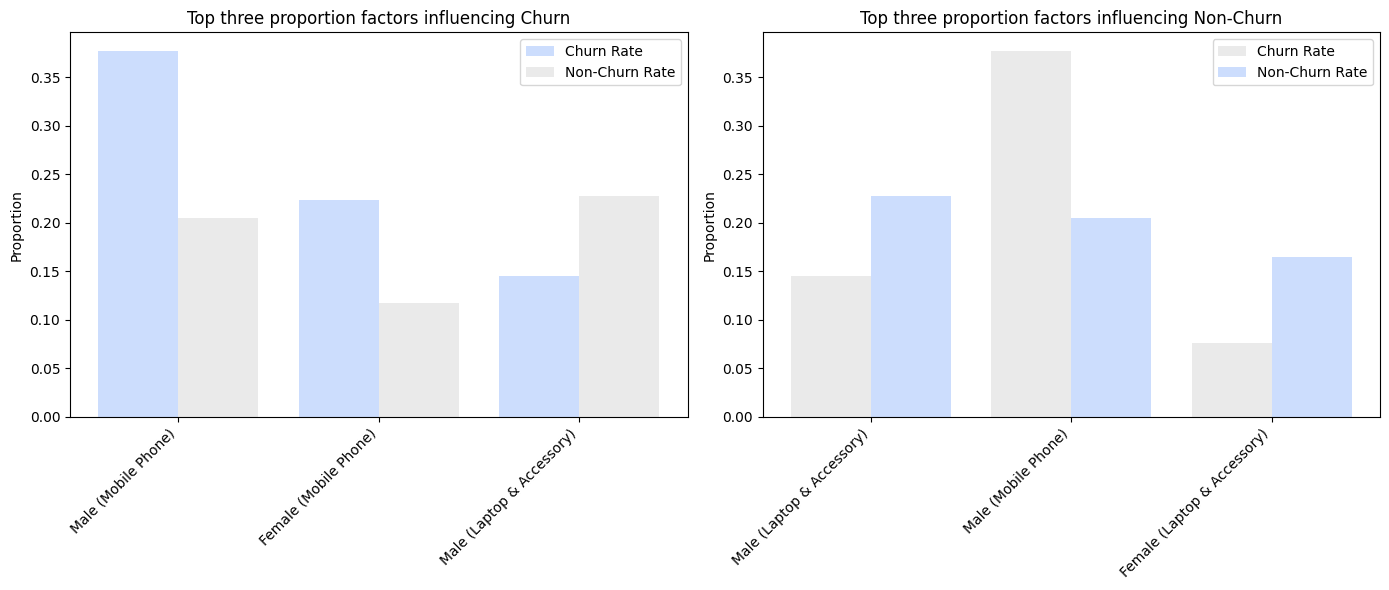

In [208]:
# Gender and PreferedOrderCat towards Churn
churn_results, nonchurn_results = calculate_churn_proportions(df, 'Gender', 'PreferedOrderCat', 'Churn')
plot_churn_and_nonchurn(churn_results, nonchurn_results, 'Gender', 'PreferedOrderCat')

- The churn proportion majority are males and females who purchased mobile phones. 
- In contrast, the non-churn proportion comes from males who bought laptops and accessories, as well as those who purchased mobile phones. 
- Notably, the churn proportion for males buying mobile phones is double that of the non-churn proportion.

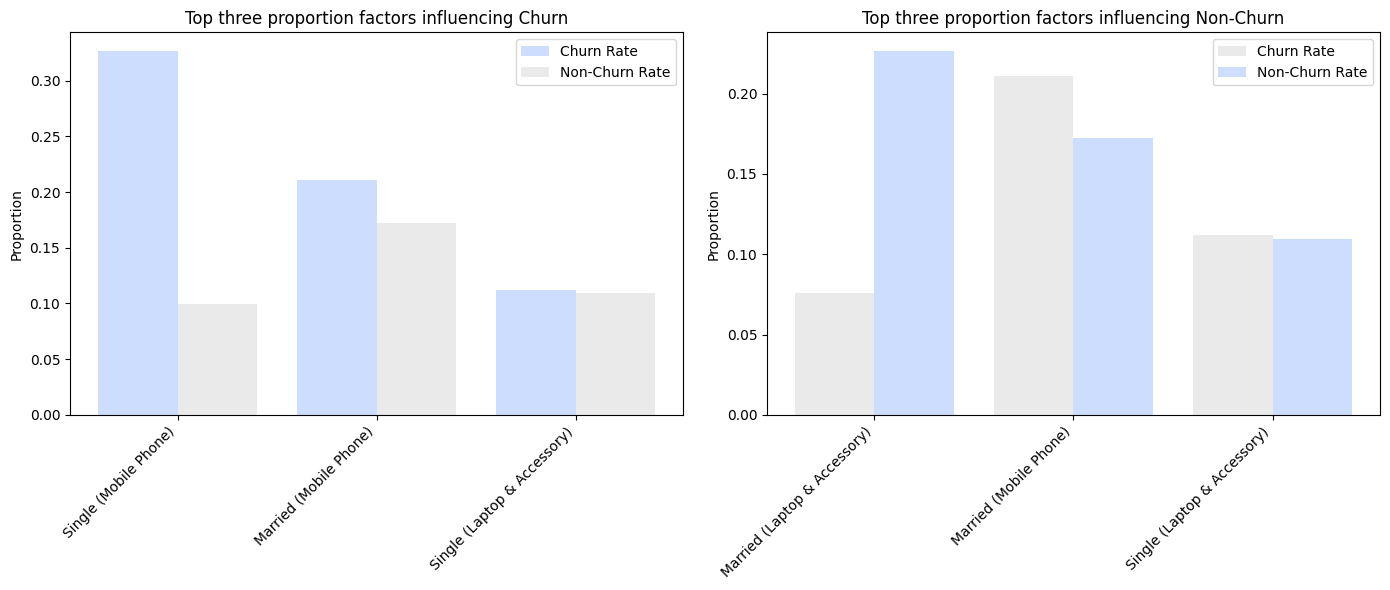

In [209]:
# Marital Status and PreferedOrderCat towards Churn
churn_results, nonchurn_results = calculate_churn_proportions(df, 'MaritalStatus', 'PreferedOrderCat', 'Churn')
plot_churn_and_nonchurn(churn_results, nonchurn_results, 'MaritalStatus', 'PreferedOrderCat')

Both married and single individuals buying mobile phones showing the highest churn rates. In comparison, married couples who purchase laptops and mobile phones experience lower churn. Notably, whether single or married, buying a mobile phone has the most impact on churn.

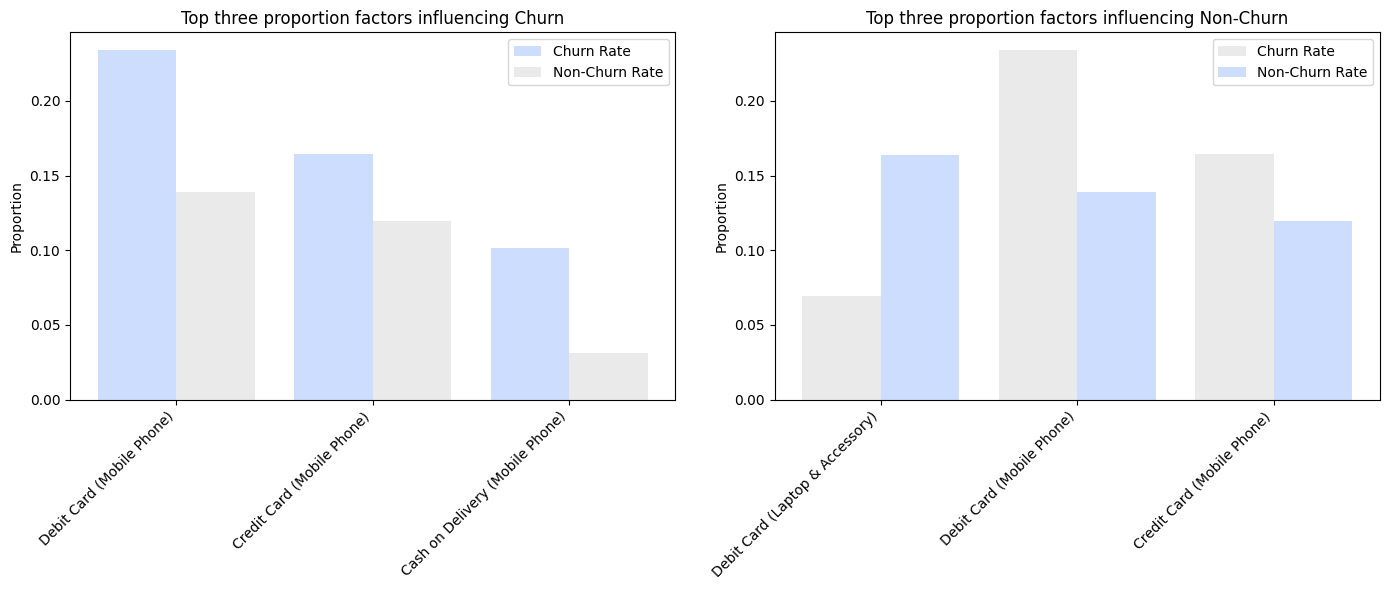

In [210]:
# Preferred Payment Mode and PreferedOrderCat towards Churn
churn_results, nonchurn_results = calculate_churn_proportions(df, 'PreferredPaymentMode', 'PreferedOrderCat', 'Churn')
plot_churn_and_nonchurn(churn_results, nonchurn_results, 'PreferredPaymentMode', 'PreferedOrderCat')

Customers' purchases of mobile phones are a common factor, regardless of the payment methods they choose. This implies that the people who purchase phones are the main source of our consumers' dissatisfaction.

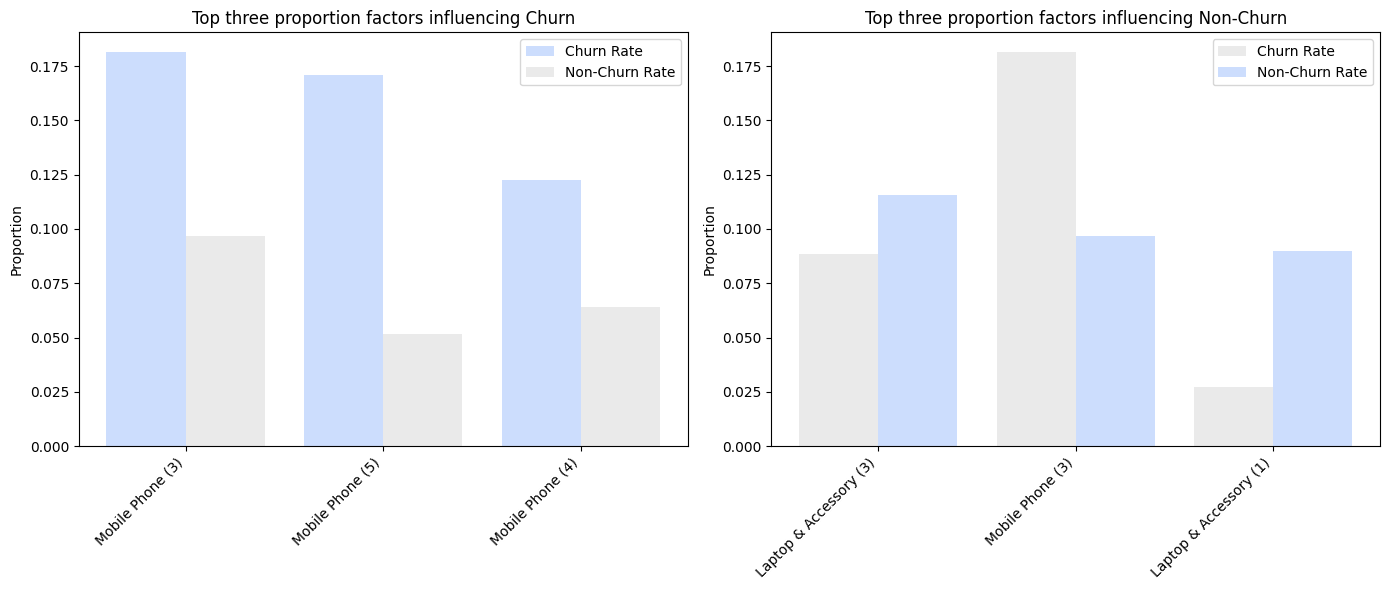

In [211]:
# SatisfactionScore and PreferedOrderCat towards Churn
df_copy = df.copy()
df_copy['SatisfactionScore'] = df_copy['SatisfactionScore'].astype('str')
churn_results, nonchurn_results = calculate_churn_proportions(df_copy, 'PreferedOrderCat', 'SatisfactionScore',  'Churn')
plot_churn_and_nonchurn(churn_results, nonchurn_results, 'PreferedOrderCat',  'SatisfactionScore')

The majority of satisfaction scores for churn rates fall between 3 and 5. When comparing churn and non-churn customers who rated their mobile phone experience a 3, the churn rate is twice as high for those customers. This supports the past findings that one of the main causes of churn is mobile phone purchases.

In [212]:
# df.to_csv('df_customer.csv', index=False)

# 5 - Feature Engineering

### Remove Unused Data

In [213]:
# Dropping the CustomerID column

df.drop(['CustomerID'], axis=1, inplace=True)

In [214]:
# Check any duplicate before modelling

df.duplicated().sum()

558

In [215]:
# Drop any duplicate

df.drop_duplicates(inplace=True)

In [216]:
# # New Data after dropping

# df.shape

The `Customer ID` column does not contribute to the model, so it should be removed prior to modeling. After checking for duplicates, it was found that there were over 500 duplicates. Following their removal, the dataset now contains 5,072 entries.  # ENTAH DIAPUS ATAU TIDAK, KALO GAK DIAPUS, RECALLNYA TURUN

### Splitting Dataset

In [217]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [218]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4057, 18)
(1015, 18)
(4057,)
(1015,)


After splitting with 80% for training and 20% for testing, the data is divided into two sets:
- Training Set: Contains 4,504 entries and 18 features. This set is used to train the model.
- Testing Set: Contains 1,126 entries and 18 features. This set is used to evaluate the model's performance.

### Data Transforming

In [219]:
num_columns = X_train.select_dtypes(exclude='object').columns
cat_columns = X_train.select_dtypes(include='object').columns

In [220]:
# Pipeline for nominal data
pipeline_categorical = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoding', OneHotEncoder(dtype=int))
])

# PipeLine for numerical data without standardization
pipeline_numerical_without_scaler = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

transformer_treebased = ColumnTransformer([
    ('categorical_transform', pipeline_categorical, cat_columns),
    ('numerical_transform', pipeline_numerical_without_scaler, num_columns)
], remainder='passthrough')


For the tree-family modelling, we need to tranform the data into numerical for categorical type and using imputation for numerical features.
- `PreferredLoginDevice`: Imputed using the most frequent value and one-hot encoded to create binary columns for each device type.
- `PreferredPaymentMode`: Imputed and one-hot encoded to differentiate payment preferences.
- `Gender`: Imputed and one-hot encoded to capture gender-related trends.
- `Complain`: Imputed and one-hot encoded to analyze complaint patterns.
- `PreferedOrderCat`: Imputed and one-hot encoded to reflect customer preferences in product categories.
- `MaritalStatus`: Imputed and one-hot encoded to understand demographic influences.


- `Tenure`: Imputed using the median to handle missing values while retaining its continuous nature.
- `WarehouseToHome`: Median imputation applied to manage missing data related to delivery logistics.
- `HourSpendOnApp`: Imputed with the median to maintain a measure of customer engagement.
- `NumberOfDeviceRegistered`: Median imputation applied to indicate customer device usage.
- `SatisfactionScore`: Imputed using the median to keep a crucial metric for customer happiness.
- `NumberOfAddress`: Median imputation applied to reflect customer flexibility.
- `Complain`: Imputed and treated as a categorical feature to analyze frequency of complaints.
- `OrderAmountHikeFromLastYear`: Imputed with the median to understand purchasing trends.
- `CouponUsed`: Median imputation applied to capture promotional engagement.
- `OrderCount`: Imputed using the median to quantify customer loyalty.
- `DaySinceLastOrder`: Median imputation for missing values to track customer engagement.
- `CashbackAmount`: Imputed with the median to retain data on financial incentives.

In [221]:
# fit column transformer
transformer_treebased.fit(X_train)

# Result of column tranformer
features = list(transformer_treebased.get_feature_names_out())

list_features = []
for feature in features:
    list_features.append(''.join(feature.split('__')[-1]))


transform_results_tree_df = pd.DataFrame(
    transformer_treebased.transform(X_train),
    columns = list_features)

In [222]:
display(transform_results_tree_df.head(5))

,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E-Wallet,PreferredPaymentMode_Unified Payment Identifier,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,13.0,2.0,3.0,1.0,2.0,0.0,19.0,1.0,1.0,5.0,123.40
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,21.0,1.0,12.0,3.0,4.0,3.0,6.0,0.0,15.0,1.0,2.0,2.0,308.00
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,7.0,4.0,5.0,5.0,3.0,0.0,13.0,1.0,4.0,3.0,147.18
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,2.0,3.0,3.0,7.0,0.0,17.0,0.0,2.0,1.0,143.82
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,3.0,3.0,5.0,1.0,0.0,13.0,3.0,7.0,6.0,128.67


The `pipeline_categorical` handles nominal data by imputing missing values with the most frequent category and applying one-hot encoding. `pipeline_numerical_without_scaler`, also imputes numerical data but skips scaling. `transformer_treebased` turning the data into numerical values and excludes scaling for numerical data.

After the transformation, the dataset is ready for modelling.

# 6 - Methodology (Analysis/Modeling)

### Benchmarking before resampling

Since our dataset contains outliers, we decided to uses tree-family model to minimize the impact of it.

In [223]:
# Tree based models
dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)
ada = AdaBoostClassifier(dtree, random_state=RANDOM_STATE)
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
gbm = GradientBoostingClassifier(random_state=RANDOM_STATE)
xgbc = XGBClassifier(random_state=RANDOM_STATE)
lgbm = LGBMClassifier(random_state=RANDOM_STATE)

In [224]:
# Model lists
tree_model = [dtree, ada, rfc, gbm, xgbc, lgbm]

# Results lists
model_name = []
score = []
train_score = []
std_value = []

# Stratified K-Fold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate based models
for model in tree_model:
    model_pipeline = Pipeline([
        ('transformer', transformer_treebased),
        ('model', model)
    ])

    model_cv = cross_val_score(
        model_pipeline,
        X_train,
        y_train,
        
        cv=skfold,
        scoring='recall',
        error_score='raise'
    )

    # print(f"{model.__class__.__name__}: {model_cv}")

    # Storing results
    score.extend(model_cv)
    train_score.append(model_cv.mean())
    std_value.append(model_cv.std())
    model_name.append(model.__class__.__name__)


[LightGBM] [Info] Number of positive: 538, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 3245, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165794 -> initscore=-1.615738
[LightGBM] [Info] Start training from score -1.615738
[LightGBM] [Info] Number of positive: 538, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 3245, number of used features: 30
[LightGBM] [Info] [binary:Bo

In [225]:
# Benchmark model result

benchmark_model_before_resampling = pd.DataFrame({
    'Model': model_name,
    'Recall score on validation set': train_score,
}).sort_values(by='Recall score on validation set', ascending=False).reset_index(drop=True)

benchmark_model_before_resampling

,Model,Recall score on validation set
0,XGBClassifier,0.826258
1,LGBMClassifier,0.817413
2,DecisionTreeClassifier,0.795047
3,AdaBoostClassifier,0.784610
4,RandomForestClassifier,0.741548
5,GradientBoostingClassifier,0.661305


the `XGBClassifier` achieved the highest recall score of 0.826, indicating its effectiveness in predictive performance. The LGBMClassifier follows closely with a recall score of 0.817, demonstrating strong capabilities as well. Because of the target our machine learning is above 90% and not using the resampling tecnique still far from that, we will try resampling technique to boost the performance. 

### Benchmarking after resampling

We will employ resampling techniques, specifically the `Over Sampler Method`, using approaches like `SMOTE` and `Random Over Sampler`. These methods will duplicate minority data to balance the majority class, which is particularly important given the small size of our dataset. Using an under-sampling approach isn’t the best option in this case, as it could lead to a loss of valuable information.

In [226]:
# Resampling techniques
SMOTE = SMOTE(random_state=RANDOM_STATE)
ros = RandomOverSampler(random_state=RANDOM_STATE)

# List of models and resampling techniques
tree_model = [dtree, ada, rfc, gbm, xgbc, lgbm]
resampling_methods = [SMOTE, ros]
resampling_names = ['SMOTE', 'RandomOverSampler']

results_train = []

# Cross-validation with resampling on training data
for resample_method, resample_name in zip(resampling_methods, resampling_names):
    for model in tree_model:
        pipeline = Pipeline([
            ('transformer', transformer_treebased),
            ('balancing', resample_method),
            ('model', model)
        ])

        model_cv_scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=5,
            scoring='recall',
            error_score='raise'
        )

        results_train.append({
            'Model': model.__class__.__name__,
            'Resampling': resample_name,
            'Recall Score on Validation Set': model_cv_scores.mean()
        })

# Convert training results to DataFrame
train_score_after_resampling = pd.DataFrame(results_train)

[LightGBM] [Info] Number of positive: 2707, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6603
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2707, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6595
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [227]:
train_score_after_resampling.sort_values(by='Recall Score on Validation Set', ascending=False).head(5)

,Model,Resampling,Recall Score on Validation Set
11,LGBMClassifier,RandomOverSampler,0.906291
10,XGBClassifier,RandomOverSampler,0.894406
4,XGBClassifier,SMOTE,0.857258
9,GradientBoostingClassifier,RandomOverSampler,0.854350
8,RandomForestClassifier,RandomOverSampler,0.846833


After applying the resampling technique, we observed a significant increase in recall for the `LGBMClassifier`, which reached 0.906, making it the best-performing model after-resampling. The `XGBClassifier` also showed improvement, achieving a recall score of 0.894. We noted enhancements in the `GradientBoostingClassifier` and `RandomForestClassifier` as well, with recall scores of 0.854 and 0.847, respectively. Using resampling technique, isn't must, but in this case using Random Over Sampler will be the best option to generalize data imbalanced.

### Hyperparameter Tuning

#### XGBC

In [250]:
# # GRID SEARCH FOR XGBC

# # Resampling techniques
# ros = RandomOverSampler(random_state=RANDOM_STATE)

# # Hyperparameter  for XGBClassifier
# hyperparam_xgbc = {
#     'model__n_estimators':[100,200,300,400,500],
#     'model__learning_rate':[0.01,0.05,0.1,0.5,1,5],
#     'model__max_depth':np.arange(15,16,17),
#     'model__alpha':np.arange(0,1,0.1),
#     'model__lambda':np.arange(0,1,0.1)
# }

# # Model
# xgbc = XGBClassifier(random_state=RANDOM_STATE)

# # Algorithm chains
# estimator_xgbc = Pipeline([
#     ('transformer', transformer_treebased),  # Ensure this is defined
#     ('balancing', ros),
#     ('model', xgbc)
# ])

# # Grid Search setup
# grid_xgbc = GridSearchCV(
#     estimator_xgbc,
#     param_grid=hyperparam_xgbc,
#     cv=5,
#     scoring='recall',
#     n_jobs=-1,
#     verbose=1
# )

In [251]:
# grid_xgbc.fit(X_train, y_train)

In [252]:
# Before

model_xgbc = Pipeline([
    ('transformer', transformer_treebased),
    ('balancing', ros),
    ('model', xgbc)
])

model_xgbc.fit(X_train, y_train)
scores_xgbc_before_tuning = cross_val_score(model_xgbc, X_train, y_train, cv=5, scoring='recall')  # 5-fold CV
print(f'Mean Recall: {scores_xgbc_before_tuning.mean()}')

# y_pred_xgbc_before_tuning = model_xgbc.predict(X_test)
# print(classification_report(y_test, y_pred_xgbc_before_tuning))

Mean Recall: 0.8944057490326147


In [253]:
# # After Tuning XGBC with GridSearchCV

# best_params_xgbc_after_tuning = grid_xgbc.best_params_
# print(best_params_xgbc_after_tuning)

In [254]:
# After tuning XGBoost with best parameters
param_xgbc_tuning = XGBClassifier(
    alpha=0.7000000000000001,
    lambda_=0.1,
    learning_rate=0.05,
    max_depth=15,
    n_estimators=200,
    objective='binary:logistic'
)

# Create the pipeline
xgbc_tuning = Pipeline([
    ('transformer', transformer_treebased),
    ('balancing', ros),
    ('model', param_xgbc_tuning) 
])

# Fit the pipeline to the training data
xgbc_tuning.fit(X_train, y_train)

# Perform cross-validation to evaluate the model
scores_xgbc_after_tuning = cross_val_score(xgbc_tuning, X_train, y_train, cv=5, scoring='recall')  # 5-fold CV
print(f'Mean Recall: {scores_xgbc_after_tuning.mean()}')


Mean Recall: 0.8943725815367607


Best Parameters: {'model__alpha': 0.7000000000000001, 'model__lambda': 0.1, 'model__learning_rate': 0.05, 'model__max_depth': 15, 'model__n_estimators': 200}


After the tuning process, the model's performance declined (recall and accuracy score), suggesting that using the `XGBClassifier` without tuning, along with `RandomOverSampler` (ROS), is a more appropriate choice for this dataset. 

#### LGBM

In [255]:
# Before

model_lgbm = Pipeline([
    ('transformer', transformer_treebased),
    ('balancing', ros),
    ('model', lgbm)
])

model_lgbm.fit(X_train, y_train)
scores_lgbm_before_tuning = cross_val_score(model_lgbm, X_train, y_train, cv=5, scoring='recall')  # 5-fold CV
print(f'Mean Recall: {scores_lgbm_before_tuning.mean()}')

[LightGBM] [Info] Number of positive: 3384, number of negative: 3384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2707, number of negative: 2707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2707, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

In [256]:
# GRID SEARCH FOR LGBM

# # parameter for LGBM
# param_grid = {
#     'model__boosting_type': ['gbdt', 'dart'],
#     'model__learning_rate': [0.01, 0.05, 0.1],
#     'model__max_depth': [5, 10, 15, 20],
#     'model__objective': ['binary']
# }

# # Initialize GridSearchCV
# grid_lgbm = GridSearchCV(model_lgbm, param_grid, cv=5, scoring='recall' )

# # Fit the model
# grid_lgbm.fit(X_train, y_train)

# # Get the best parameters and best score
# best_estimator = grid_lgbm.best_estimator_
# print(f'Best Parameters: {grid_lgbm.best_params_}')
# print(f'Best Recall Score: {grid_lgbm.best_score_}')


The LGBM model shows good in accuracy and recall scores both before and after resampling. However, in terms of business impact, it falls short compared to the XGBC model before tuning.

In [257]:
# # Saving best params for LGBM

# best_params_lgbm_after_tuning = grid_lgbm.best_params_
# print("Best Parameters:", best_params_lgbm_after_tuning)

Best Parameters: {'model__boosting_type': 'gbdt', 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__objective': 'binary'}

In [258]:
# After tuning LGBM with best parameters
param_lgbm_tuning = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.1,
    max_depth=15,
    objective='binary'
)

lgbm_tuning = Pipeline([
    ('transformer', transformer_treebased),
    ('balancing', ros),
    ('model', param_lgbm_tuning) 
])

lgbm_tuning.fit(X_train, y_train)

# Perform cross-validation 
scores_lgbm_after_tuning = cross_val_score(lgbm_tuning, X_train, y_train, cv=5, scoring='recall')  # 5-fold CV
print(f'Mean Recall: {scores_lgbm_after_tuning.mean()}')

[LightGBM] [Info] Number of positive: 3384, number of negative: 3384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2707, number of negative: 2707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2707, number of negative: 27

#### Random Forest 

In [259]:
# Before

model_rfc = Pipeline([
    ('transformer', transformer_treebased),
    ('balancing', ros),
    ('model', rfc)
])

model_rfc.fit(X_train, y_train)
scores_rfc_before_tuning = cross_val_score(model_rfc, X_train, y_train, cv=5, scoring='recall')  # 5-fold CV
print(f'Mean Recall: {scores_rfc_before_tuning.mean()}')


Mean Recall: 0.8468325041459369


In [260]:
# # Tuning Random Forest 
# param_grid = {
#     'model__n_estimators': [50, 100, 200],  # Prefix with 'model__'
#     'model__max_features': ['auto', 'sqrt', 'log2'],
#     'model__max_depth': [10, 20, 30],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4]
# }

# # Initialize GridSearchCV
# grid_rfc = GridSearchCV(model_rfc, param_grid, cv=5, scoring='recall')

# # Fit the model with tuning
# grid_rfc.fit(X_train, y_train)

# # After Tuning
# best_params_rfc_after_tuning = grid_rfc.best_params_
# best_score_rfc_after_tuning = grid_rfc.best_score_

# print("Best Parameters:", best_params_rfc_after_tuning)
# print("Best Score:", best_score_rfc_after_tuning)

The Random Forest model shows good in accuracy and recall scores both before and after resampling. However, in terms of business impact, it falls short compared to the XGBC model and LGBM

In [261]:
# # After Tuning Random Forest with GridSearchCV best parameters
# grid_rfc.best_params_

{'model__max_depth': 30,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 200}

In [262]:
# After tuning Random Forest with best parameters
param_rfc_tuning = RandomForestClassifier(
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200
)

# Create the pipeline
rfc_tuning = Pipeline([
    ('transformer', transformer_treebased),
    ('balancing', ros),
    ('model', param_rfc_tuning)
])

# Fit the pipeline to the training data
rfc_tuning.fit(X_train, y_train)

# Perform cross-validation to evaluate the model
scores_rfc_after_tuning = cross_val_score(rfc_tuning, X_train, y_train, cv=5, scoring='recall')  # 5-fold CV
print(f'Mean Recall: {scores_rfc_after_tuning.mean()}')


Mean Recall: 0.8676948590381427


### Best Model

In [263]:
# Print all model score and their confussion matrix

print('XGBC before tuning')
print(f'Mean Recall: {scores_xgbc_before_tuning.mean()}')

print('XGBC after tuning')
print(f'Mean Recall: {scores_xgbc_after_tuning.mean()}')

print('LGBM before tuning')
print(f'Mean Recall: {scores_lgbm_before_tuning.mean()}')

print('LGBM after tuning')
print(f'Mean Recall: {scores_lgbm_after_tuning.mean()}')

print('RFC before tuning')
print(f'Mean Recall: {scores_rfc_before_tuning.mean()}')

print('RFC after tuning')
print(f'Mean Recall: {scores_rfc_after_tuning.mean()}')


XGBC before tuning
Mean Recall: 0.8944057490326147
XGBC after tuning
Mean Recall: 0.8943725815367607
LGBM before tuning
Mean Recall: 0.9062907683803205
LGBM after tuning
Mean Recall: 0.9137313432835821
RFC before tuning
Mean Recall: 0.8468325041459369
RFC after tuning
Mean Recall: 0.8676948590381427


In [242]:
# Final model
model_final = lgbm_tuning

In [243]:
model_final

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical_transform',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_encoding',
                                                                                          OneHotEncoder(dtype=<class 'int'>))]),
                                                                         Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'Mari...
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object'))])),
                                       ('balancing',
                                        RandomOverSampler(random_state=2024)),
                                       ('model',
                                        LGBMClassifier(random_state=2024))]),
             param_grid={'model__boosting_type': ['gbdt', 'dart'],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [5, 10, 15, 20],
                         'model__objective': ['binary']},
             scoring='recall')

In [244]:
# model final on test data
y_pred_final = model_final.predict(X_test)
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       847
           1       0.90      0.95      0.92       168

    accuracy                           0.97      1015
   macro avg       0.95      0.96      0.95      1015
weighted avg       0.98      0.97      0.97      1015



In [245]:
print(confusion_matrix(y_test, y_pred_final))

[[830  17]
 [  9 159]]


In [247]:
# # Saving model final

# pickle.dump(model_final, open('model_final.pkl', 'wb'))

### Learning Curves


A learning curve evaluates how well a machine learning model performs as it learns from more data or is trained longer.

In [ ]:
# Create learning curve
train_sizes, train_scores, test_scores = \
    learning_curve(model_final, X_train, y_train, cv=skfold(n_splits=10, test_size=0.2, random_state=42),
                   train_sizes=np.linspace(0.1, 1.0, 10), scoring='recall', n_jobs=-1)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Precision")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
pd.DataFrame({'TrainingScoreMean':train_scores_mean,
              'TrainingScoreSD':train_scores_std,
              'TestScoreMean': test_scores_mean,
              'TestScoreSD':test_scores_std}).round(2)

### Feature Importance

In [264]:
# transforming test data with model xgbc
test_transformed = pd.DataFrame(
    lgbm_tuning[0].transform(X_test)
    , columns = list_features)
test_transformed

,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E-Wallet,PreferredPaymentMode_Unified Payment Identifier,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,1.0,24.0,3.0,4.0,3.0,10.0,0.0,12.0,1.0,2.0,9.0,232.39
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,3.0,27.0,4.0,2.0,2.0,2.0,0.0,13.0,2.0,3.0,3.0,152.91
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,7.0,1.0,4.0,2.0,4.0,1.0,19.0,1.0,2.0,3.0,261.03
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0,1.0,20.0,3.0,3.0,4.0,2.0,0.0,13.0,0.0,1.0,6.0,127.56
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,22.0,1.0,13.0,3.0,3.0,5.0,5.0,1.0,16.0,0.0,2.0,2.0,125.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,15.0,2.0,4.0,5.0,2.0,1.0,11.0,0.0,1.0,0.0,123.19
1011,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.0,1.0,10.0,4.0,4.0,4.0,3.0,0.0,13.0,8.0,8.0,10.0,179.33
1012,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,3.0,9.0,3.0,3.0,1.0,7.0,0.0,13.0,0.0,1.0,8.0,178.23
1013,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,18.0,1.0,14.0,3.0,4.0,1.0,2.0,1.0,15.0,2.0,2.0,11.0,315.49


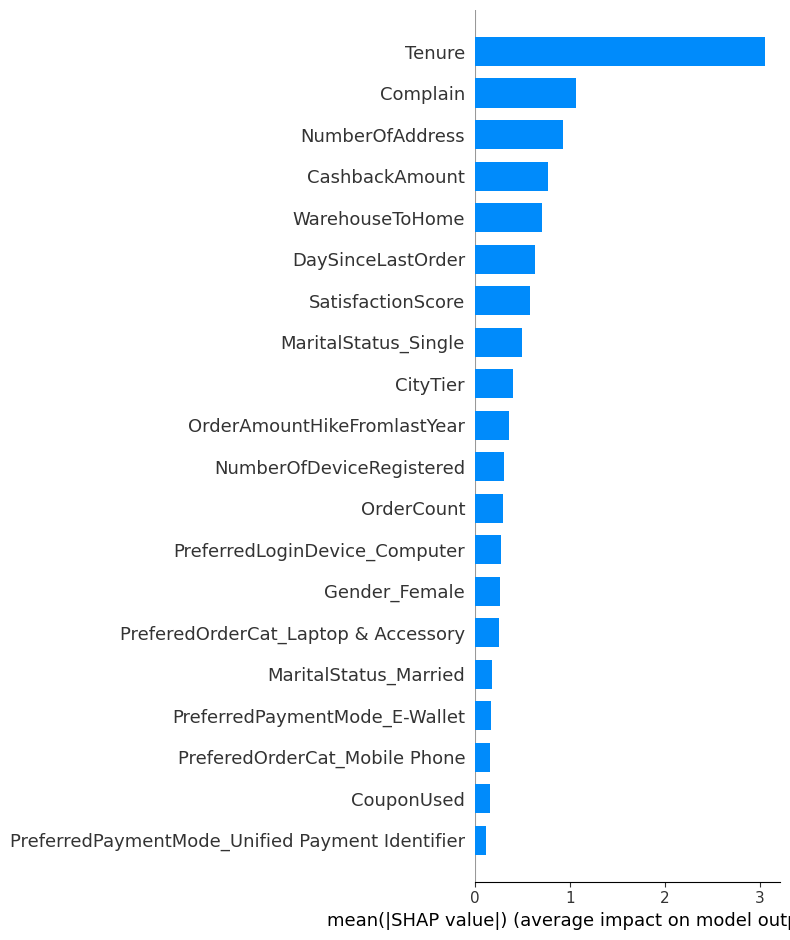

In [265]:
import shap

xgb_model = model_xgbc.named_steps['model']

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(test_transformed)

shap.summary_plot(shap_values, test_transformed, plot_type="bar")


PermutationExplainer explainer: 1016it [01:38,  9.04it/s]                          


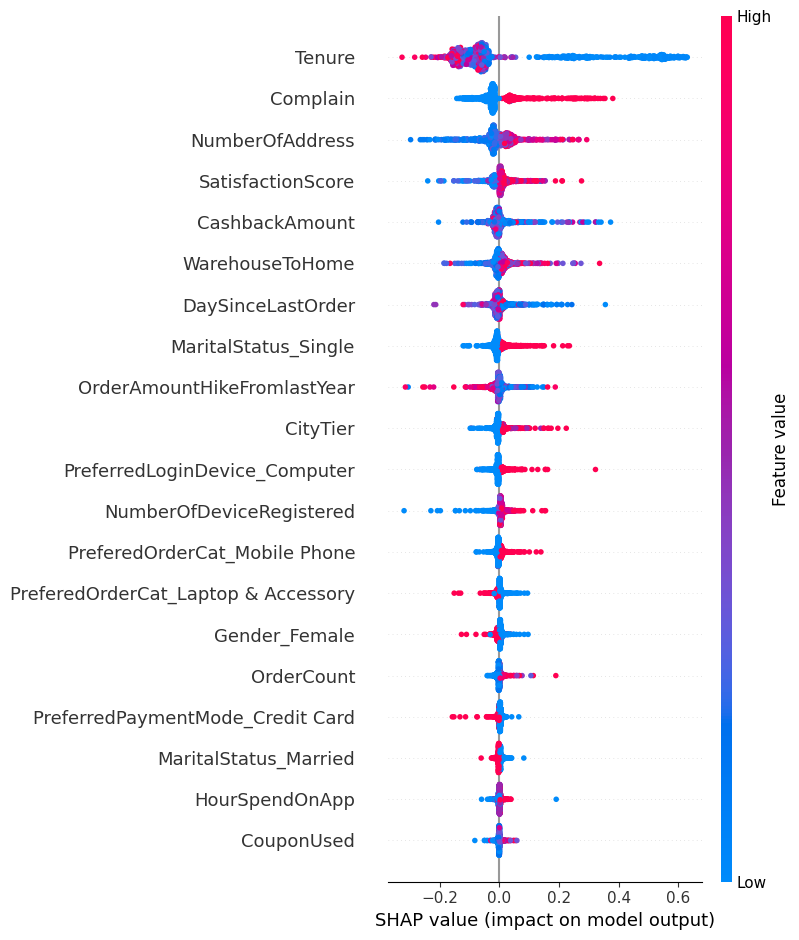

In [266]:
# explainer xgbc

explainer_xgbc = shap.Explainer(
    model_xgbc[-1].predict,
    model_xgbc[0].transform(X_test)
)

shap_values_xgbc = explainer_xgbc(test_transformed)
shap.summary_plot(shap_values_xgbc, test_transformed)

- `Tenure`: Longer tenure decreases churn likelihood.
- `Complain`: Customers who complain are more likely to churn.
- `NumberOfAddress`: More addresses correlate with higher churn.
- `WarehouseToHome`: Longer distances from warehouse to home increase churn.
- `CashbackAmount`: Higher cashback reduces churn risk.
- `SatisfactionScore`: Higher satisfaction strongly reduces churn.
- `DaySinceLastOrder`: Recent orders decrease churn risk.
- `MaritalStatus_Single`: Single customers have a slightly higher chance of churning.
- `OrderAmountHikeFromLastYear`: Increased spending from last year reduces churn.
- `NumberOfDeviceRegistered`: More registered devices slightly increase churn risk.
- `PreferedOrderCat_Laptop & Accessory`: Laptop and accessory shoppers have a higher churn tendency.
- `CityTier`: Customers in higher-tier cities are less likely to churn.
- `PreferredLoginDevice_Computer`: Desktop users are less likely to churn.
- `MaritalStatus_Married`: Married customers are more loyal, with lower churn rates.
- `PreferredPaymentMode_E-Wallet`: E-wallet users have a lower likelihood of churning.
- `OrderCount`: More frequent orders indicate lower churn.
- `PreferredPaymentMode_Credit Card`: Credit card users are slightly more likely to churn.
- `Gender_Female`: Female customers are less likely to churn than male customers.
- `PreferedOrderCat_Mobile Phone`: Mobile phone shoppers have a higher churn tendency.
- `PreferedOrderCat_Fashion`: Fashion shoppers are more prone to churn.

# 7 - Conclusion and Recommendation

### **Insight**
The company is facing a customer churn problem, with a 17% churn rate. Mobile phone users, single individuals, and customers with low tenure (1–6 months) are the most likely to churn. Cashback incentives and satisfaction scores are strong indicators of churn, with higher cashback amounts and satisfaction reducing the risk of churn. Additionally, proximity to the warehouse appears to influence churn rates, particularly for customers living closer, who may have higher expectations regarding delivery speed.

### **Recommendation for Modeling**
Based on the model evaluation, **LGBM after tuning** with RandomOverSampler (ROS) provides the most accurate and cost-effective results for predicting churn. It achieves a recall score of 91.3%, capturing the majority of high-risk churn customers, while maintaining a low total error cost.

- **Preferred Model**: LGBM with RandomOverSampler, which offers slightly lower performance but is still competitive. 
- **Alternative Model**: XGBoost Classifier before tuning with RandomOverSampler.

### **Recommendation for Business**
1. **Focus on Early Tenure Customers**: Since customers with low tenure (1–6 months) are more prone to churn, retention efforts like personalized promotions or discounts during this period could significantly improve customer loyalty.
2. **Leverage Cashback Offers**: Increasing cashback incentives, especially for mobile phone purchases, can help reduce churn, as this category has the highest churn tendency.
3. **Mobile App Improvement**: Enhance user experience and engagement on the mobile app, as mobile phone users show a higher likelihood of churn. Introduce features that increase usage time and provide seamless navigation.
4. **Customer Experience Centers**: Consider opening physical branches or offering in-store product demonstrations near warehouses to meet the expectations of customers in close proximity and reduce churn.
5. **Targeted Campaigns**: Single customers and mobile phone shoppers should be the focus of retention campaigns, as these groups are at the highest risk of churning.

### **Business Impact after Model Implementation**
- **Improved Customer Retention**: By accurately identifying and retaining high-risk customers, the company can reduce the churn rate, potentially lowering acquisition costs and increasing lifetime value.
- **Cost Efficiency**: Implementing the XGBoost model minimizes unnecessary retention efforts on non-churned customers, reducing the cost per customer by approximately **$3 per false positive**. The reduction in churn will also save the business **$20 per customer** lost to churn, improving overall profitability.
- **Marketing Optimization**: The model allows for more focused marketing spend, targeting customers most likely to churn, rather than broad, less effective retention strategies.

### **Model Limitations**
- **Imbalanced Dataset**: Despite resampling techniques like RandomOverSampler, the imbalanced dataset (83% non-churn, 17% churn) may still cause challenges in generalizing to new data, particularly with minority churn cases.
- **Sensitivity to Outliers**: Although tree-based models like XGBoost handle outliers better than linear models, the presence of outliers in features such as `OrderCount` and `CouponUsed` might still affect predictions.
- **Limited Data**: The dataset contains only 5,630 entries, which may limit the model’s ability to detect all potential patterns. Additional data would be beneficial for improving model robustness.




**Cost Analysis of Implementing ML vs. Not Implementing ML**

**Confusion Matrix Interpretation**
|                   | Predicted Non-Churn |  Predicted Churn |
|-------------------|------------------|---------------------|
| **Actual Non-Churn**  |    830 (TN)      |   17 (FP)            |
|  **Actual Churn**|  9 (FN)      |    159 (TP)         |

**Cost Definitions**
- **CRC (Customer Retention Cost)**: $3 (cost to retain an existing customer)


**Cost Without Implementing ML**
Assuming all customers are treated as churned, the cost would be based on the total dataset:

- **Total Customers**: N = 1015
- **Total Cost Without ML**: 
  Total Cost = N × CRC
  Total Cost Without ML = 1015 × 20 = $20,300

**Cost With Implementing ML**
Using the confusion matrix, we can calculate the costs based on true and false predictions:

1. **Cost for Retaining Customers**:
   - **True Positives (TP)**: 159 (customers correctly predicted to churn)
   - **Total Retention Cost**: 
   Total Retention Cost = TP × CRC = 159 × 3 = $477

2. **Cost for Acquiring New Customers**:
   - **False Negatives (FN)**: 9 (customers incorrectly predicted as non-churn)
   - **Total Acquisition Cost**: 
   Total Acquisition Cost = FN × CAC = 9 × $3 = $27

4. **Total Cost With ML**:
   Total Cost With ML = Total Retention Cost + Total Acquisition Cost + Total Acquisition Cost for FP
   Total Cost With ML = 477 + 27 = $504

**Summary of Costs**
- **Cost Without Implementing ML**: 
  Cost Without ML = 20,300

- **Cost With Implementing ML**: $504

- **Savings by Implementing ML**: 
  Savings = Cost Without ML - Cost With ML
  Savings = 20,300 - 997 = $19,



In [2]:
20300 - 477 + 27

19850